# 6.5 Detailed Performance Analysis with Michel Events Removed
Additional training runs were completed. Note that training runs >=2 were run for 20 Epochs, whereas 0&1 were run for 10.

In [1]:
import sys
import os
import h5py
from collections import Counter
from progressbar import *
import re
import numpy as np
import itertools
from tqdm import tqdm
from repeating_classifier_training_utils import *

# Add the path to the parent directory to augment search for module
par_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

if par_dir not in sys.path:
    sys.path.append(par_dir)
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [3]:
tia_path = '/data/WatChMaL/data/Best_ResNet18_Model/'
dump_dir = '/home/cmacdonald/CNN/dumps/'
repeat_path_1 = os.path.join(dump_dir,'20200506_104330_repeat1')
repeat_path_2 = os.path.join(dump_dir,'20200521_134726_repeat2')
repeat_path_3 = os.path.join(dump_dir,'20200522_145528_repeat3')
repeat_path_4 = os.path.join(dump_dir,'20200522_153524_repeat4')
repeat_path_5 = os.path.join(dump_dir,'20200525_110037_repeat5')
paths = list([tia_path,repeat_path_1,repeat_path_2,repeat_path_3,repeat_path_4,repeat_path_5])
npz_path = os.path.join(os.getcwd(),'Index_Storage')
LABEL_DICT = {0:"gamma", 1:"e", 2:"mu"}
softmax_index_dict = {value:key for key, value in LABEL_DICT.items()}

## Plot Training History

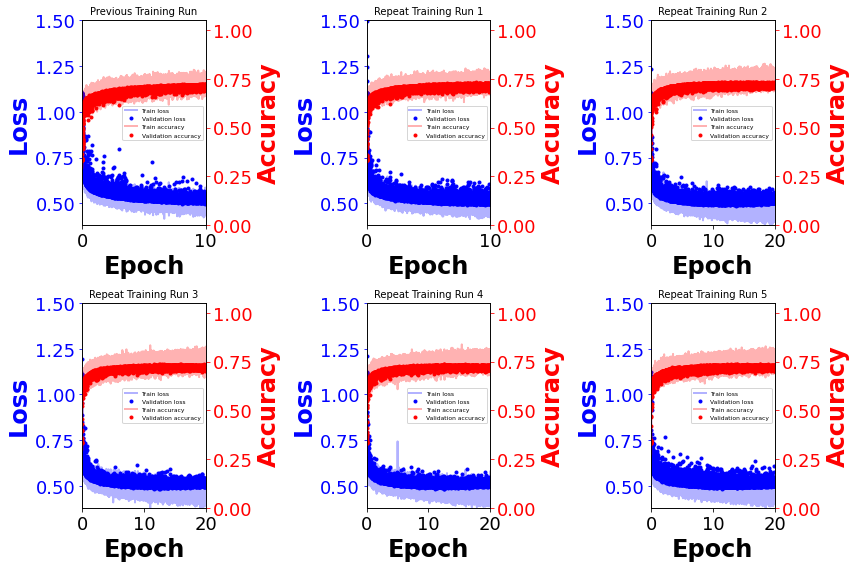

In [4]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=['Previous Training Run' if i == 0 else 'Repeat Training Run {i}'.format(i=i) for i,_ in enumerate(paths)],leg_font=6)

## Plot Training History, Where Best Models Were Saved

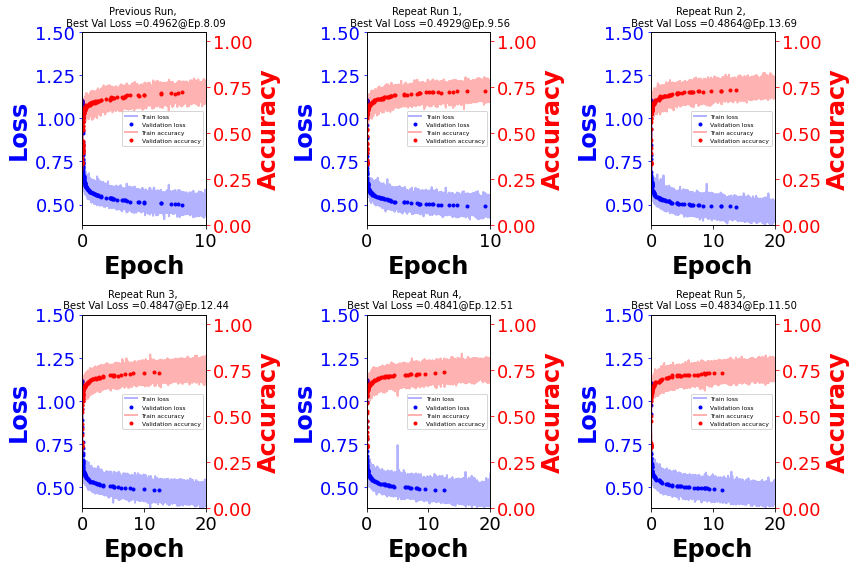

In [5]:
fig = disp_multiple_learn_hist(paths,losslim=1.5,titles=['Previous Run' if i == 0 else 'Repeat Run {i}'.format(i=i) for i,_ in enumerate(paths)],best_only=True,leg_font=6)

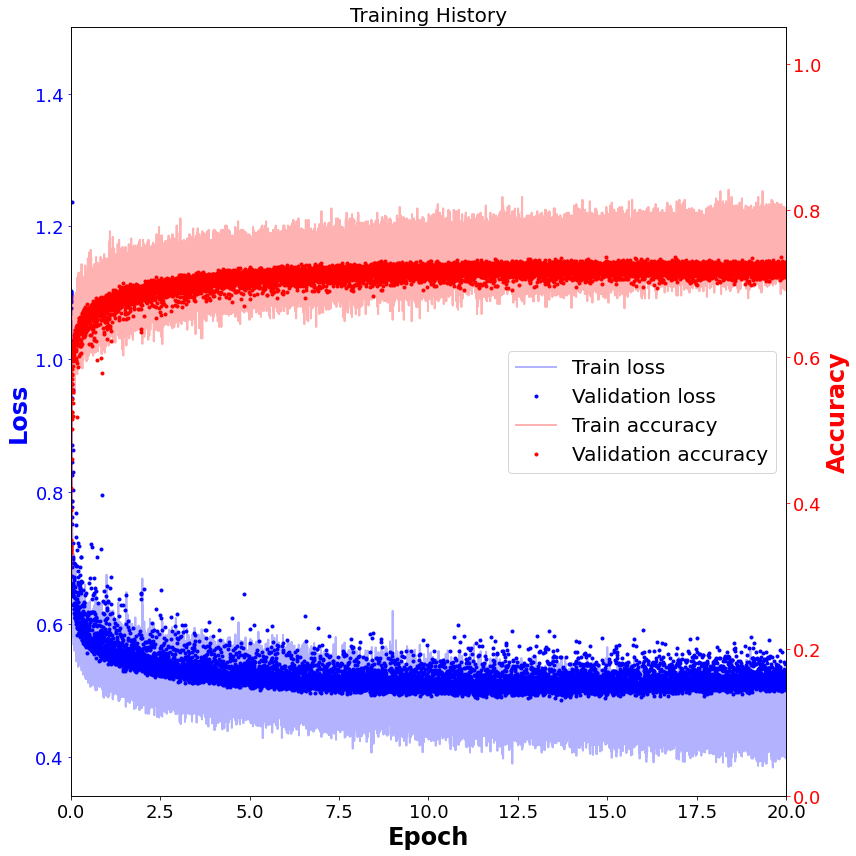

In [6]:
fig = disp_multiple_learn_hist([paths[2]],losslim=1.5,titles=['Training History'],leg_font=20, title_font=20)

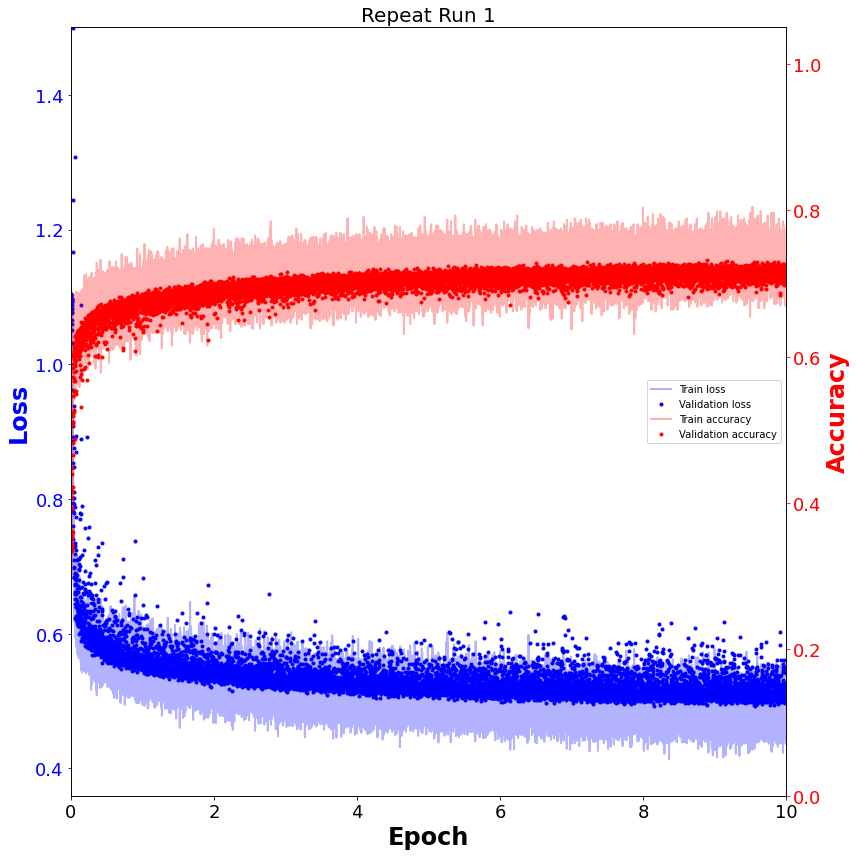

In [7]:
fig = disp_multiple_learn_hist([paths[1]],losslim=1.5,titles=['Repeat Run 1'],best_only=False,title_font=20)
plt.savefig(os.path.join(os.getcwd(),'plot_images/repeat_training.pdf'))

## Plot Confusion Matrices

In [8]:
paths[0] =  "/home/cmacdonald/CNN/dumps/20200519_152505_test_with_tias_model" #this was the test I ran with Tia's pretrained weights, but with sequential dataloader
paths[1] =  "/home/cmacdonald/CNN/dumps/20200511_151728_repeat1_test"
test_output = [load_test_output(os.path.join(loc,'test_validation_iteration_dump.npz'),npz_path) for loc in paths]

In [9]:
veto_path = '/fast_scratch/WatChMaL/data/michels.h5'
mv_file = h5py.File(veto_path,'r')
mv_info = {}
for key in mv_file.keys():
    mv_info[key] = np.array(mv_file[key])

In [10]:
test_output[2].keys()

dict_keys(['filtered_predictions', 'filtered_softmaxes', 'filtered_labels', 'filtered_energies', 'filtered_rootfiles', 'filtered_eventids', 'filtered_angles'])

In [11]:
mv_dict = {}
pbar = ProgressBar(widgets=['Creating All-False Dictionary: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(test_output[2]['filtered_eventids']))
pbar.start()
for i in range(len(test_output[2]['filtered_eventids'])):
    mv_dict[(test_output[2]['filtered_rootfiles'][i], test_output[2]['filtered_eventids'][i])] = False
    pbar.update(i)
pbar.finish()

Creating All-False Dictionary: 100% [000000000000000000000000000] Time: 0:00:10


In [12]:
pbar = ProgressBar(widgets=['Update Muon Values: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(mv_info['event_ids']))
pbar.start()
for i, is_michel in enumerate(mv_info['is_michel']):
    mv_dict[(mv_info['root_files'][i], mv_info['event_ids'][i])] = is_michel
    pbar.update(i)
pbar.finish()

Update Muon Values: 100% [00000000000000000000000000000000000000] Time: 0:00:10


In [13]:
michel = []
pbar = ProgressBar(widgets=['Creating All-False Dictionary: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(test_output[2]['filtered_eventids']))
pbar.start()
for i in range(len(test_output[2]['filtered_eventids'])):
    michel.append(mv_dict[(test_output[2]['filtered_rootfiles'][i], test_output[2]['filtered_eventids'][i])])
    pbar.update(i)
pbar.finish()

Creating All-False Dictionary: 100% [000000000000000000000000000] Time: 0:00:10


In [14]:
michel_idxs = np.where(np.array(michel)==True)[0]

In [15]:
michel_idxs.shape[0]/np.where(test_output[2]['filtered_labels']==2)[0].shape[0]

0.014567117349188446

In [16]:
for output in test_output:
    for key in output.keys():
        output[key] = np.delete(output[key], michel_idxs, 0)

In [17]:
for output in test_output:
    for key in output.keys():
        assert output[key].shape[0]==2600740

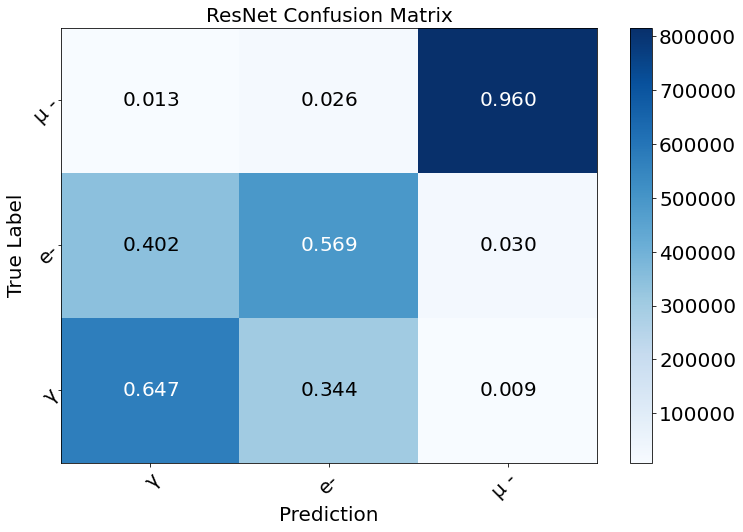

In [18]:
repeat_1 = test_output[2]
plot_confusion_matrix(repeat_1['filtered_labels'],repeat_1['filtered_predictions'],['\u03B3','e-','\u03BC -'],title='ResNet Confusion Matrix')

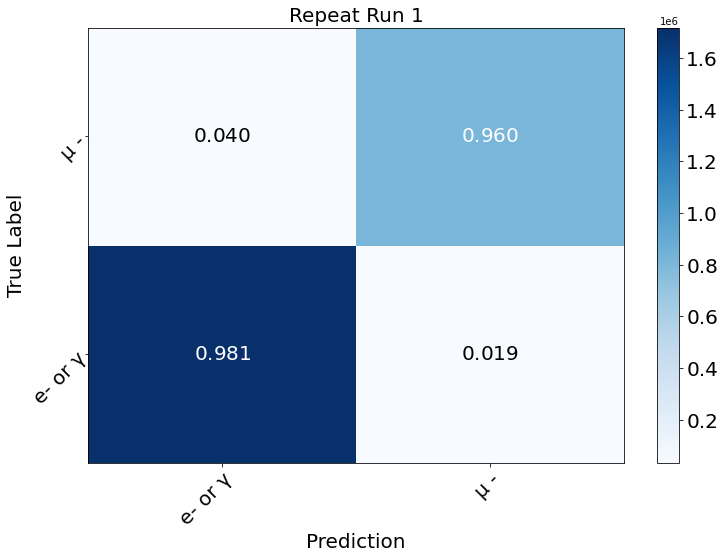

In [19]:
collapsed_sm_1, collapsed_labels_1, collapsed_predictions_1= collapse_test_output(repeat_1['filtered_softmaxes'],
                                                                 repeat_1['filtered_labels'],
                                                                 softmax_index_dict,
                                                                 predictions = repeat_1['filtered_predictions'])
fig = plot_confusion_matrix(collapsed_labels_1-1,collapsed_predictions_1-1,
                            ['e- or \u03B3','\u03BC -'],title='Repeat Run 1')

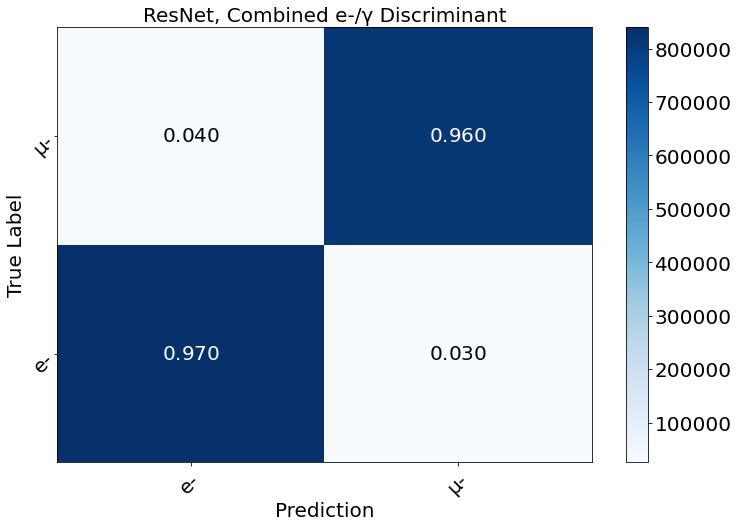

In [20]:
collapsed_sm_1, collapsed_labels_1, collapsed_predictions_1= collapse_test_output(repeat_1['filtered_softmaxes'],
                                                                 repeat_1['filtered_labels'],
                                                                 softmax_index_dict,
                                                                 predictions = repeat_1['filtered_predictions'])
emu_idxs = np.where(repeat_1['filtered_labels']!=0)[0]
fig = plot_confusion_matrix(collapsed_labels_1[emu_idxs]-1,collapsed_predictions_1[emu_idxs]-1,
                            ['e-','\u03BC-'],title='ResNet, Combined e-/\u03B3 Discriminant')

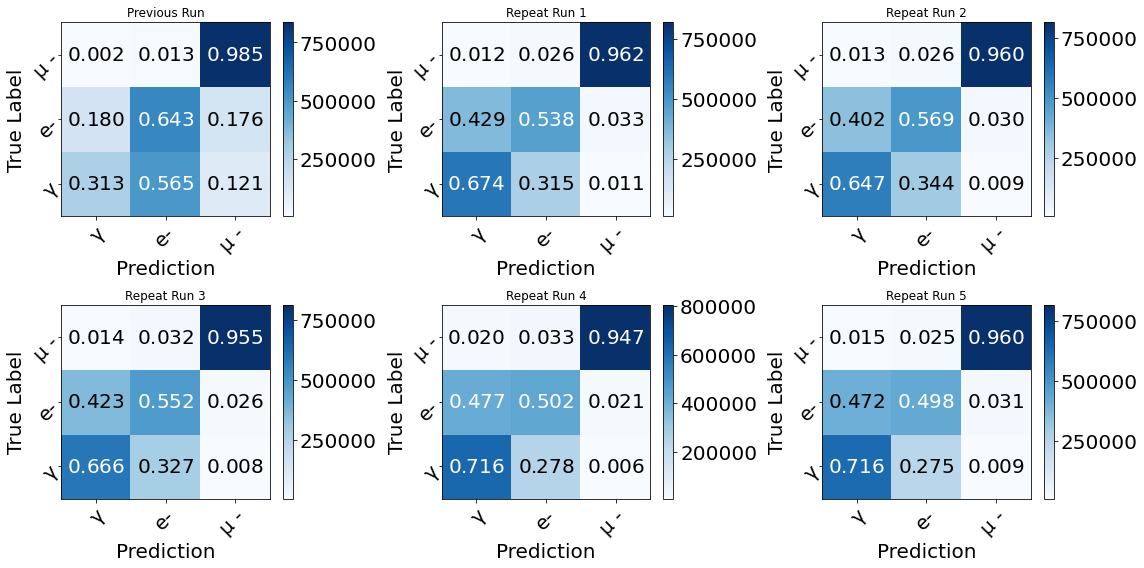

In [21]:
fig = plot_multiple_confusion_matrix([output['filtered_labels'] for output in test_output], [output['filtered_predictions'] for output in test_output],
                               ['\u03B3','e-','\u03BC -'],titles=['Previous Run' if i == 0 else 'Repeat Run {i}'.format(i=i) for i,_ in enumerate(paths)])

## ROC Curves

In [22]:
fprs, tprs, thresholds = zip(*[prep_roc_data(output['filtered_softmaxes'],output['filtered_labels'],
                                'rejection',softmax_index_dict,"e","mu",energies=output['filtered_energies'],) for output in test_output]
                            )

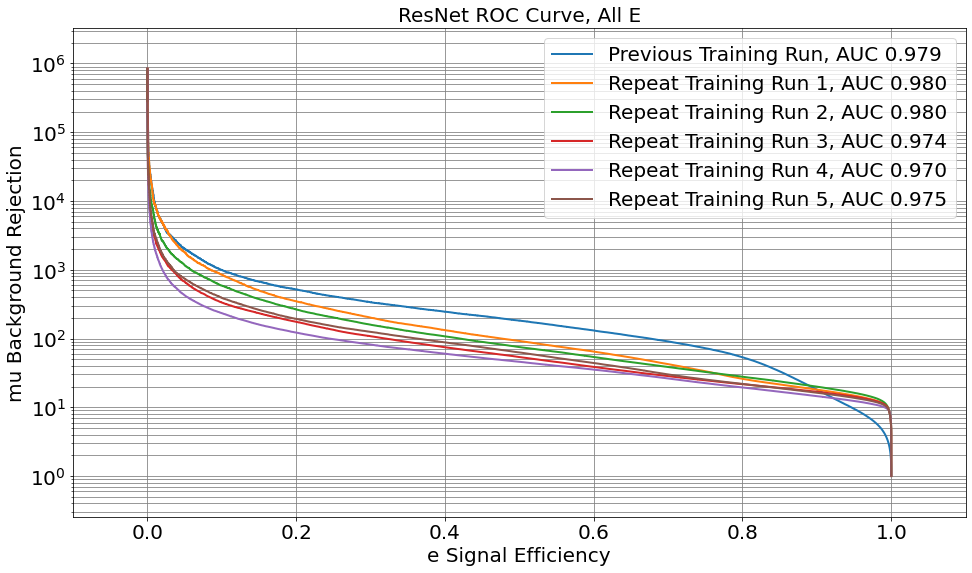

In [23]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', ["e", "mu"], 
                                plot_labels=['Previous Training Run' if i == 0 else 'Repeat Training Run {i}'.format(i=i) for i,_ in enumerate(paths)],
                                png_name = 'overlaid_roc',title='ResNet ROC Curve, All E',annotate=False)

In [24]:
collapsed_sm_1, collapsed_labels_1 = collapse_test_output(repeat_1['filtered_softmaxes'],
                                                                 repeat_1['filtered_labels'],
                                                                 softmax_index_dict, ignore_type="gamma")
fprs, tprs, thresholds = zip(*[prep_roc_data(repeat_1['filtered_softmaxes'],repeat_1['filtered_labels'],
                                'rejection',softmax_index_dict,"e","mu"),
                                prep_roc_data(collapsed_sm_1,collapsed_labels_1, 'rejection',softmax_index_dict, "e","mu")]
                            )

In [25]:
# Load the fiTQun results

# File paths for fiTQun results
fiTQun_e_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_e-.npz"
fiTQun_mu_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_mu-.npz"
fiTQun_gamma_path = "/fast_scratch/WatChMaL/data/IWCDmPMT_4pi_fulltank_fiTQun_gamma.npz"

# Load fiTQun results
f_e = np.load(fiTQun_e_path, allow_pickle=True)
f_mu = np.load(fiTQun_mu_path, allow_pickle=True)
f_gamma = np.load(fiTQun_gamma_path, allow_pickle=True)

e_filenames = f_e['filename']
mu_filenames = f_mu['filename']
gamma_filenames = f_gamma['filename']
e_eventid = f_e['eventid']
mu_eventid = f_mu['eventid']
gamma_eventid = f_gamma['eventid']

e_flag = np.array(f_e['flag'])
e_indices = np.where((e_flag[:,0] == 0) & (e_flag[:,1] == 0))[0]
e_flagindices = np.where((e_flag[:,0] != 0) | (e_flag[:,1] != 0))[0]
mu_flag = np.array(f_mu['flag'])
mu_indices = np.where((mu_flag[:,0] == 0) & (mu_flag[:,1] == 0))[0]
mu_flagindices = np.where((mu_flag[:,0] != 0) | (mu_flag[:,1] != 0))[0]
gamma_flag = np.array(f_gamma['flag'])
gamma_indices = np.where((gamma_flag[:,0] == 0) & (gamma_flag[:,1] == 0))[0]
gamma_flagindices = np.where((gamma_flag[:,0] != 0) | (gamma_flag[:,1] != 0))[0]

print(e_flag.shape)

# Get the nLL for each event
# The first nLL value is for electron hypothesis and second nLL is for the muon hypothesis
e_nLL = np.array(f_e['nLL'])
e_nLL = e_nLL[e_indices]
mu_nLL = np.array(f_mu['nLL'])
mu_nLL = mu_nLL[mu_indices]
gamma_nLL = np.array(f_gamma['nLL'])
gamma_nLL = gamma_nLL[gamma_indices]

# Find the raw nLL differences
e_nLL_diff_e = e_nLL[:,1] - e_nLL[:,0]
mu_nLL_diff_e = mu_nLL[:,1] - mu_nLL[:,0]
gamma_nLL_diff_e = gamma_nLL[:,1] - gamma_nLL[:,0]

e_nLL_diff_mu = e_nLL[:,0] - e_nLL[:,1]
mu_nLL_diff_mu = mu_nLL[:,0] - mu_nLL[:,1]
gamma_nLL_diff_mu = gamma_nLL[:,0] - gamma_nLL[:,1]

# labels
e_labels_mu = np.ones(e_nLL_diff_mu.shape)
mu_labels_mu = np.ones(mu_nLL_diff_mu.shape)*2
e_labels_e = np.ones(e_nLL_diff_e.shape)
mu_labels_e = np.ones(mu_nLL_diff_e.shape)*2

# concatenate labels and differences from mu and e events
diff_mu = np.concatenate((mu_nLL_diff_mu, e_nLL_diff_mu), axis=0).astype(int)
labels_mu = np.concatenate((mu_labels_mu, e_labels_mu), axis=0).astype(int)
diff_e = np.concatenate((mu_nLL_diff_e, e_nLL_diff_e), axis=0).astype(int)
labels_e = np.concatenate((mu_labels_e, e_labels_e), axis=0).astype(int)

fit_fpr, fit_tpr, fit_threshold = roc_curve(labels_e, diff_e,pos_label=1)

fprs = list(fprs)
tprs = list(tprs)
thresholds = list(thresholds)

fprs.append(fit_fpr)
tprs.append(fit_tpr)
thresholds.append(fit_threshold)

(1118723, 2)


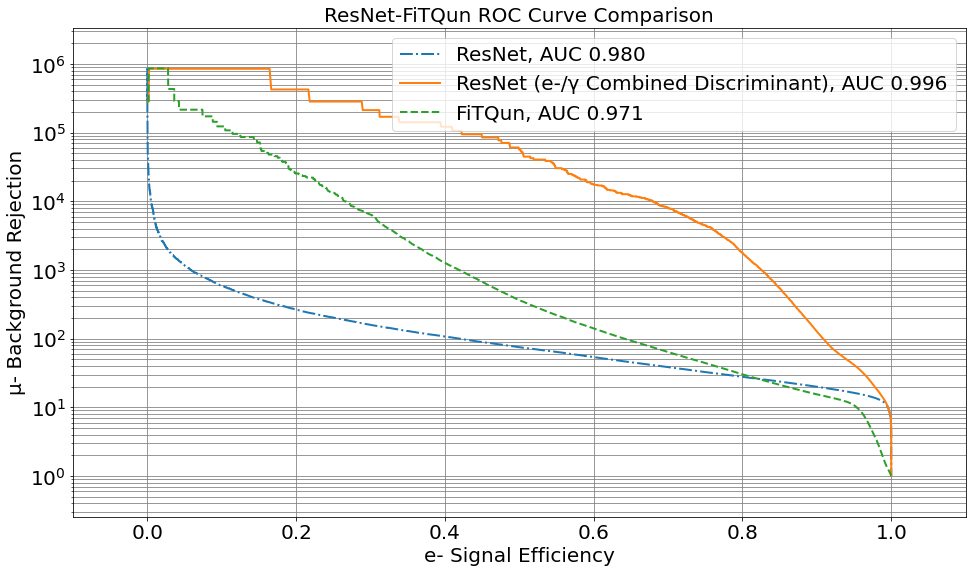

In [26]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "mu"],['e','mu'],['e','mu']], 
                                plot_labels = ['ResNet', 'ResNet (e-/\u03B3 Combined Discriminant)','FiTQun'],
                                png_name = 'overlaid_roc',title='ResNet-FiTQun ROC Curve Comparison',annotate=False,
                                linestyle=('dashdot','-','--'), xlabel='e- Signal Efficiency',ylabel='\u03BC- Background Rejection')
# plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison.pdf'))

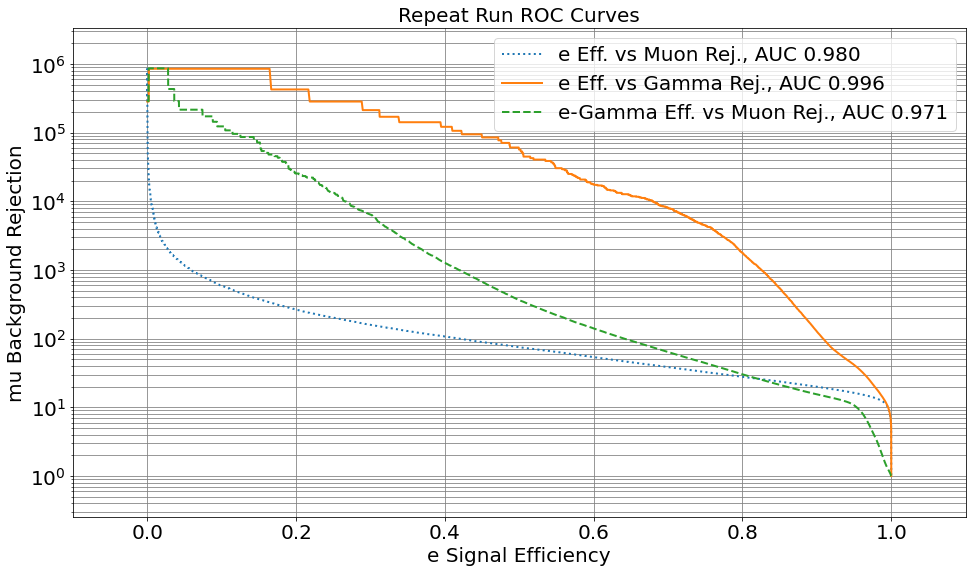

In [27]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "mu"],['e','gamma'],['e','mu'],['e','mu']], 
                                plot_labels = ['e Eff. vs Muon Rej.', 'e Eff. vs Gamma Rej.', 'e-Gamma Eff. vs Muon Rej.','FiTQun e Eff. vs Muon Rej.'],
                                png_name = 'overlaid_roc',title='Repeat Run ROC Curves',annotate=False,linestyle=(':','-','--','dashdot'))
plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison.pdf'))

In [28]:
fractions, tprs, fprs, thresholds = zip(*[prep_roc_data(repeat_1['filtered_softmaxes'],repeat_1['filtered_labels'],
                                'fraction',softmax_index_dict,"e","mu"),
                                prep_roc_data(repeat_1['filtered_softmaxes'],repeat_1['filtered_labels'],
                                'fraction',softmax_index_dict,"e","gamma"),
                                prep_roc_data(collapsed_sm_1,collapsed_labels_1, 'fraction',
                                              softmax_index_dict, "e","mu")]
                            )

fq_fps, fq_tps, fq_thresholds = binary_clf_curve(labels_e,diff_e,pos_label=softmax_index_dict['e'])
fq_fns = fq_tps[-1] - fq_tps
fq_tns = fq_fps[-1] - fq_fps

tprs+=(fq_tps / (fq_tps + fq_fns),)
fractions+=(fq_tns / (fq_tns + fq_fps),)
fprs+=(fq_fps / (fq_fps + fq_tns),)
thresholds+=(fq_thresholds,)

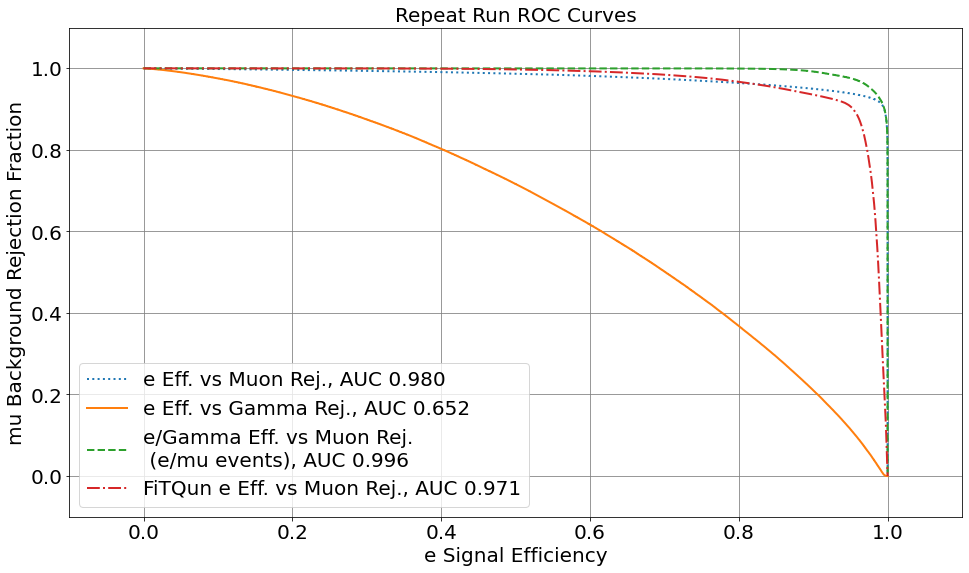

In [29]:
roc_metrics = plot_multiple_ROC((fractions, tprs, fprs, thresholds),'fraction', [["e", "mu"],['e','gamma'],['e','mu'],['e','mu']], 
                                plot_labels = ['e Eff. vs Muon Rej.', 'e Eff. vs Gamma Rej.', 'e/Gamma Eff. vs Muon Rej. \n (e/mu events)','FiTQun e Eff. vs Muon Rej.'],
                                png_name = 'overlaid_roc',title='Repeat Run ROC Curves',annotate=False,linestyle=(':','-','--','dashdot'),
                                leg_loc='lower left')
plt.savefig(os.path.join(os.getcwd(),'plot_images/ROC_comparison_fraction.pdf'))

## Signal Purity vs Energy At Fixed Efficiency

In [30]:
tia_out = test_output[0]
GAMMA_THRESHOLD = 1.55
ELECTRON_THRESHOLD = 0.775
MUON_THRESHOLD = 160.26
shifted_energies = []

shifted_energies = np.zeros(tia_out['filtered_labels'].shape[0])
g_idxs = np.where(tia_out['filtered_labels']==0)[0]
e_idxs = np.where(tia_out['filtered_labels']==1)[0]
m_idxs = np.where(tia_out['filtered_labels']==2)[0]
shifted_energies[g_idxs] = np.squeeze(tia_out['filtered_energies'][g_idxs] - GAMMA_THRESHOLD)
shifted_energies[e_idxs] = np.squeeze(tia_out['filtered_energies'][e_idxs] - ELECTRON_THRESHOLD)
shifted_energies[m_idxs] = np.squeeze(tia_out['filtered_energies'][m_idxs] - MUON_THRESHOLD)

In [31]:
fq_filename_original = (f_gamma['filename'],f_e['filename'],f_mu['filename'])
fq_eventids_original = ( f_gamma['eventid'],f_e['eventid'], f_mu['eventid'])
fq_flag_original = (f_gamma['flag'] ,f_e['flag'],f_mu['flag'])
fq_nll_original = (f_gamma['nLL'],f_e['nLL'],f_mu['nLL'])
fq_mom_original = (f_gamma['momentum'],f_e['momentum'],f_mu['momentum'])

n_events = int(reduce(lambda x,y : x+y, list(map(lambda x : x.shape[0],fq_filename_original))))

fq_rootfiles = np.empty(n_events,dtype=object)
fq_eventids = np.zeros(n_events)
fq_flag = np.empty((n_events,2))
fq_nll = np.empty((n_events,2))
fq_mom = np.empty((n_events, 2))

fq_mapping_indices = np.load(os.path.join(npz_path,'fq_mapping_idxs.npz'),allow_pickle=True)['arr_0']

filtered_indices = np.load("/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz", allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']
f = h5py.File("/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5", "r")

original_eventids = np.array(f['event_ids'])
original_rootfiles = np.array(f['root_files'])
filtered_eventids = original_eventids[test_filtered_indices]
filtered_rootfiles = original_rootfiles[test_filtered_indices]
original_labels = np.array(f['labels'])
filtered_labels = original_labels[test_filtered_indices]
fq_failed_idxs = np.load(os.path.join(npz_path,'fq_failed_idxs.npz'), allow_pickle = True)['failed_indices_pointing_to_h5_test_set'].astype(int)
sfiltered_labels = np.delete(filtered_labels, fq_failed_idxs)
sfiltered_eventids = np.delete(filtered_eventids, fq_failed_idxs).astype(int)
sfiltered_rootfiles = np.delete(filtered_rootfiles , fq_failed_idxs)

pbar = ProgressBar(widgets=['Arranging FiTQun Data. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=n_events)
pbar.start()
for i,ptype in enumerate(sfiltered_labels):
    fq_rootfiles[i] = str(fq_filename_original[ptype][fq_mapping_indices[i]])
    fq_eventids[i] = fq_eventids_original[ptype][fq_mapping_indices[i]]
    fq_flag[i] = fq_flag_original[ptype][fq_mapping_indices[i]]
    fq_nll[i] = fq_nll_original[ptype][fq_mapping_indices[i]]
    fq_mom[i] = fq_mom_original[ptype][fq_mapping_indices[i]]
    pbar.update(i)
fq_scores = np.zeros((fq_nll.shape[0],3))
fq_scores[:,0] = fq_nll[:,1] - fq_nll[:,0]
fq_scores[:,1] = fq_nll[:,1] - fq_nll[:,0]
fq_scores[:,2] = fq_nll[:,0] - fq_nll[:,1]
fq_labels = sfiltered_labels
pbar.finish()

pbar = ProgressBar(widgets=['Verification Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(sfiltered_rootfiles))
pbar.start()
for i in range(len(sfiltered_rootfiles)):
    assert re.sub('_fiTQun','',fq_rootfiles[i].split('/')[-1]) == sfiltered_rootfiles[i].split('/')[-1], print(fq_rootfiles[i])
    assert fq_eventids[i] -1 == sfiltered_eventids[i]
    pbar.update(i)
pbar.finish()
assert len(sfiltered_rootfiles) == fq_rootfiles.shape[0]
print("Success! We now have a FiTQun output set in the same order as the h5 test set")

fq_scores_wflagged = fq_scores
fq_labels_wflagged = fq_labels

flagged_idxs = np.load(os.path.join(npz_path, 'fq_flagged_idxs.npz'))['arr_0']
fq_rootfiles = np.delete(fq_rootfiles, flagged_idxs)
fq_eventids = np.delete(fq_eventids, flagged_idxs)
fq_flag = np.delete(fq_flag, flagged_idxs,0)
fq_nll = np.delete(fq_nll, flagged_idxs,0)
fq_scores = np.delete(fq_scores, flagged_idxs,0)
fq_labels = np.delete(fq_labels, flagged_idxs)
fq_mom = np.delete(fq_mom, flagged_idxs, 0)

fq_rootfiles = np.delete(fq_rootfiles, michel_idxs)
fq_eventids = np.delete(fq_eventids, michel_idxs)
fq_flag = np.delete(fq_flag, michel_idxs,0)
fq_nll = np.delete(fq_nll, michel_idxs,0)
fq_scores = np.delete(fq_scores, michel_idxs,0)
fq_labels = np.delete(fq_labels, michel_idxs)
fq_mom = np.delete(fq_mom, michel_idxs, 0)

Arranging FiTQun Data. Progress: 100% [0000000000000000000000000] Time: 0:00:18
Verification Progress: 100% [00000000000000000000000000000000000] Time: 0:00:17


Success! We now have a FiTQun output set in the same order as the h5 test set


In [33]:
collapsed_sm, collapsed_labels = collapse_test_output(repeat_1['filtered_softmaxes'],
                                                                 repeat_1['filtered_labels'],
                                                                 softmax_index_dict)

### Binning in Energy

/home/cmacdonald/CNN/ResNet_Analysis/repeating_classifier_training_utils.py:966: RuntimeWarning: divide by zero encountered in true_divide
  elif metric == 'inverse fpr': performance = np.where(fps != 0, (fps +tns) / fps, fps+tns)
/home/cmacdonald/CNN/ResNet_Analysis/repeating_classifier_training_utils.py:966: RuntimeWarning: divide by zero encountered in true_divide
  elif metric == 'inverse fpr': performance = np.where(fps != 0, (fps +tns) / fps, fps+tns)


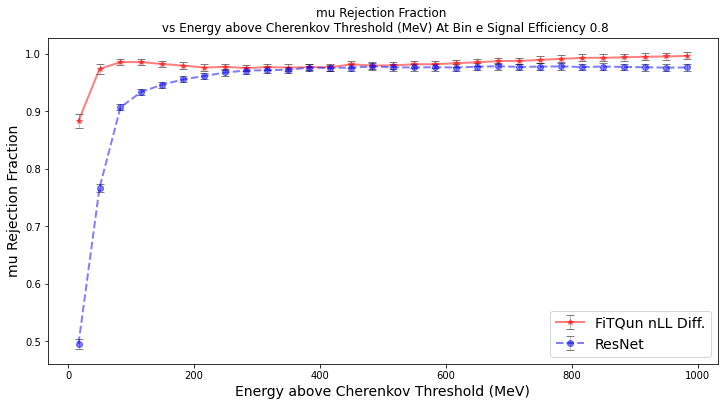

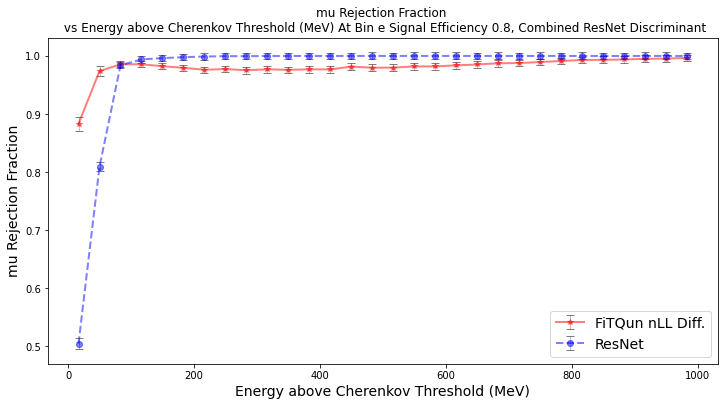

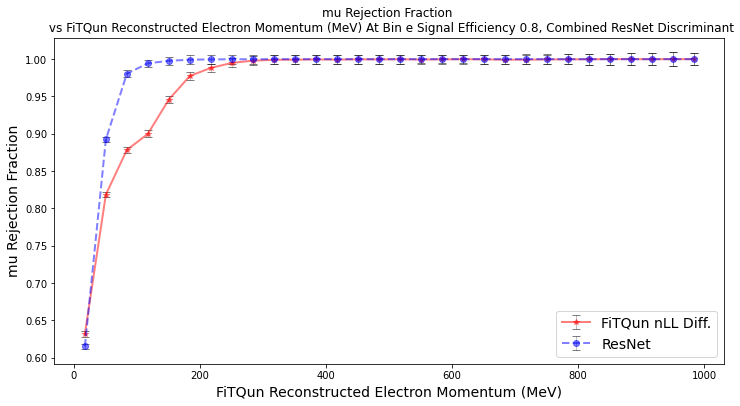

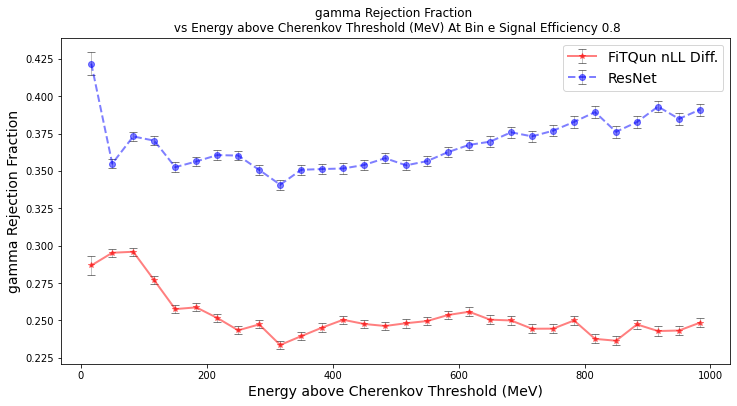

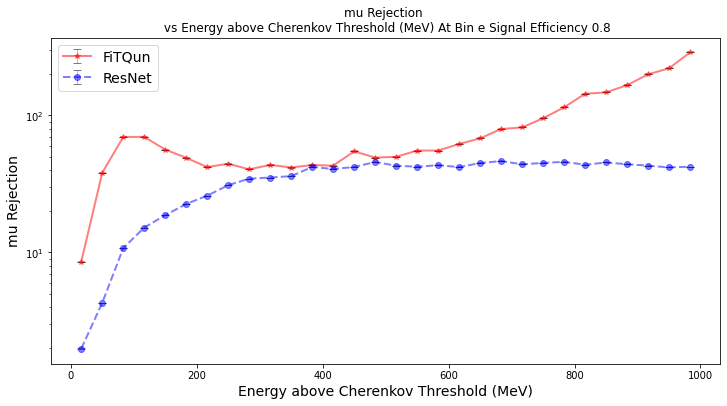

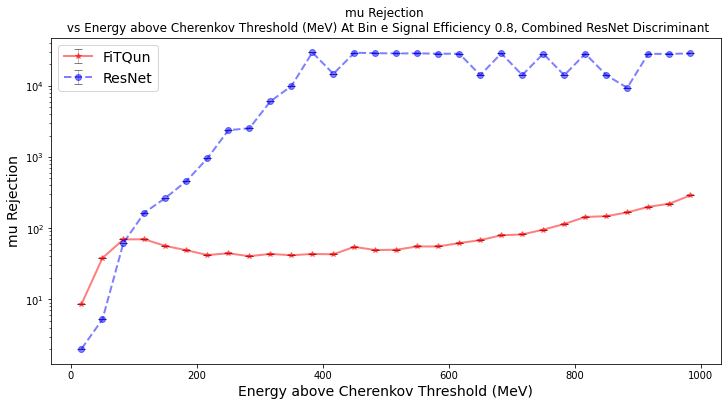

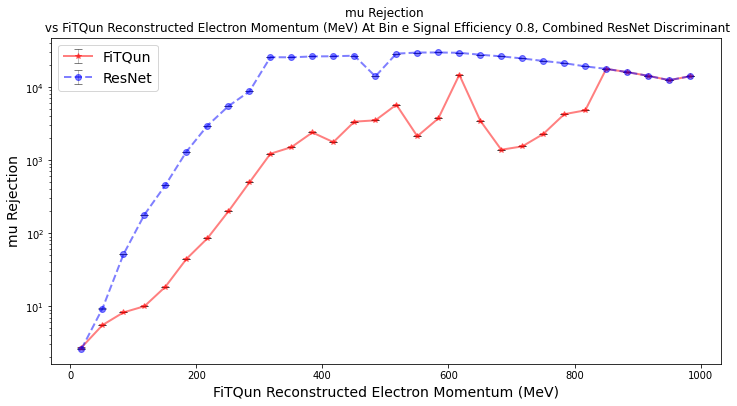

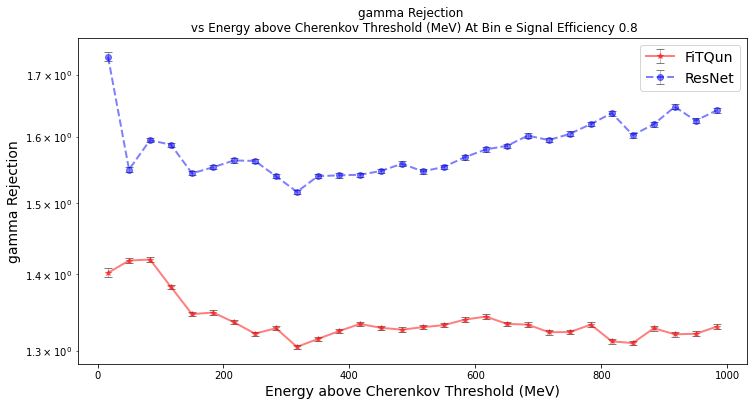

In [34]:
scores = [fq_scores, test_output[2]['filtered_softmaxes'], fq_scores, collapsed_sm, fq_scores, collapsed_sm, -fq_scores, test_output[2]['filtered_softmaxes']]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [shifted_energies,shifted_energies,np.clip(fq_mom[:,0], 0, 1000),shifted_energies]
feature_labels = ['Energy above Cherenkov Threshold (MeV)', 'Energy above Cherenkov Threshold (MeV)','FiTQun Reconstructed Electron Momentum (MeV)','Energy above Cherenkov Threshold (MeV)']
title_notes = ['',', Combined ResNet Discriminant',', Combined ResNet Discriminant','']
pos_labels = ['e','e','e','e']
neg_labels = ['mu','mu','mu','gamma']
img_names=['rejection_vs_e.pdf','rejection_vs_e_combined_disc.pdf', 'rejection_vs_recon_e_combined_disc.pdf', 'e_gamma_rejection_vs_e.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    
scores = [fq_scores, test_output[2]['filtered_softmaxes'], fq_scores, collapsed_sm, fq_scores, collapsed_sm, -fq_scores, test_output[2]['filtered_softmaxes']]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [shifted_energies,shifted_energies,np.clip(fq_mom[:,0], 0, 1000),shifted_energies]
feature_labels = ['Energy above Cherenkov Threshold (MeV)', 'Energy above Cherenkov Threshold (MeV)','FiTQun Reconstructed Electron Momentum (MeV)','Energy above Cherenkov Threshold (MeV)']
title_notes = ['',', Combined ResNet Discriminant',', Combined ResNet Discriminant','']
pos_labels = ['e','e','e','e']
neg_labels = ['mu','mu','mu','gamma']
img_names=['rejection_vs_e.pdf','rejection_vs_e_combined_disc.pdf', 'rejection_vs_recon_e_combined_disc.pdf', 'e_gamma_rejection_vs_e.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='inverse fpr',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='inverse fpr',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun','ResNet'],fontsize=14)
    if i==1:
        plt.savefig(os.path.join(os.getcwd(),'plot_images','energy_binning.pdf'))

### Binning in Energy, where dtowall >200cm

In [35]:
d_to_wall_incl_all = np.load('dist_to_wall.npz', allow_pickle=True)['test_d_to_wall']
fq_failed_idxs = np.load('Index_Storage/fq_failed_idxs.npz', allow_pickle=True)['failed_indices_pointing_to_h5_test_set']
fq_flagged_idxs = np.load('Index_Storage/fq_flagged_idxs.npz', allow_pickle=True)['arr_0']
d_to_wall_incl_flagged = np.delete(d_to_wall_incl_all, fq_failed_idxs)
d_to_wall = np.delete(d_to_wall_incl_flagged, fq_flagged_idxs)
d_to_wall = np.delete(d_to_wall, michel_idxs)

/home/cmacdonald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  after removing the cwd from sys.path.


In [36]:
dwall_over_200_idxs = np.where(d_to_wall>200)[0]

/home/cmacdonald/CNN/ResNet_Analysis/repeating_classifier_training_utils.py:966: RuntimeWarning: divide by zero encountered in true_divide
  elif metric == 'inverse fpr': performance = np.where(fps != 0, (fps +tns) / fps, fps+tns)
/home/cmacdonald/CNN/ResNet_Analysis/repeating_classifier_training_utils.py:966: RuntimeWarning: divide by zero encountered in true_divide
  elif metric == 'inverse fpr': performance = np.where(fps != 0, (fps +tns) / fps, fps+tns)


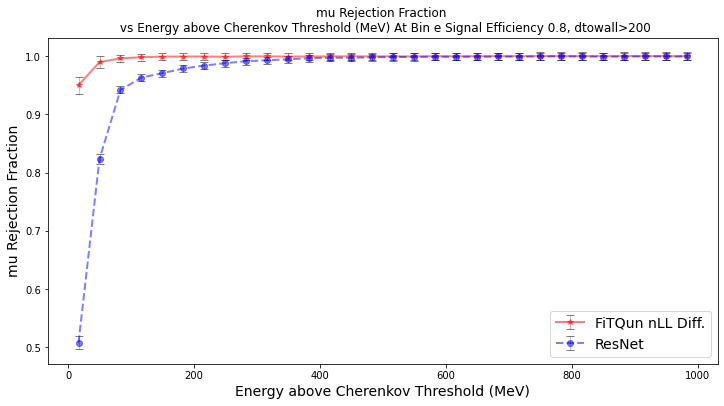

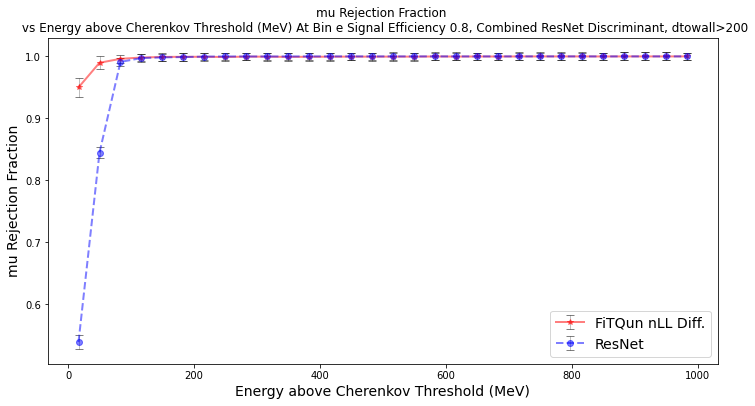

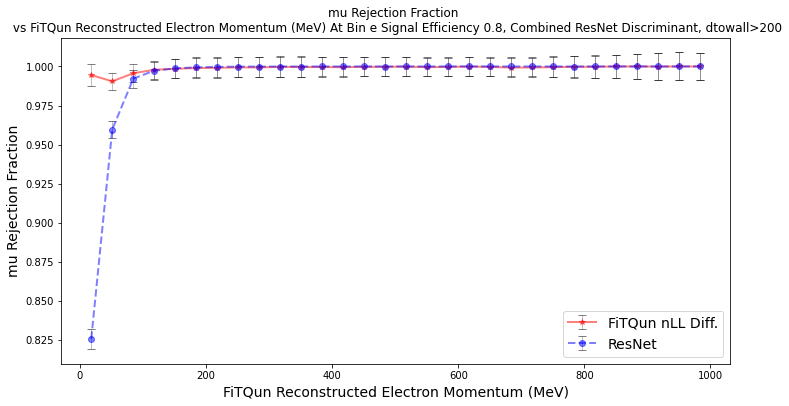

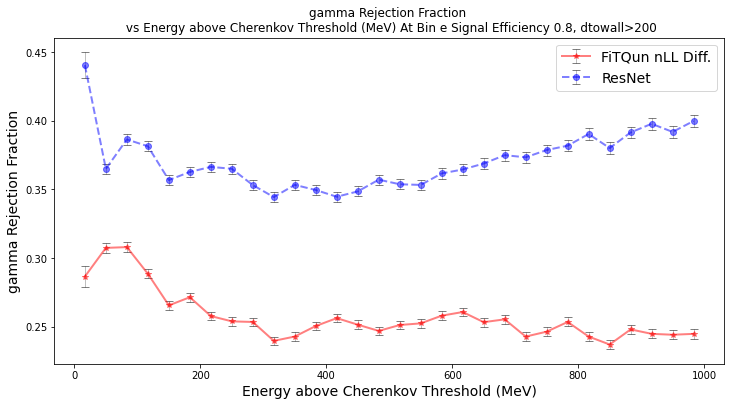

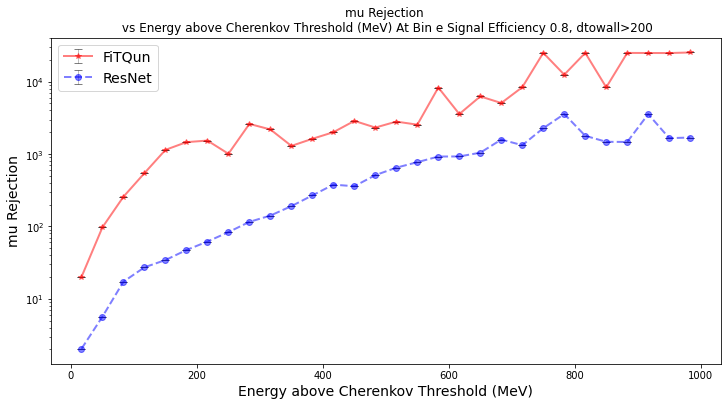

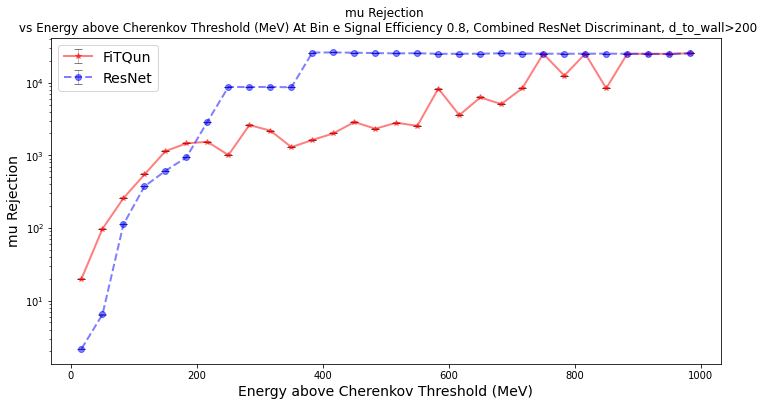

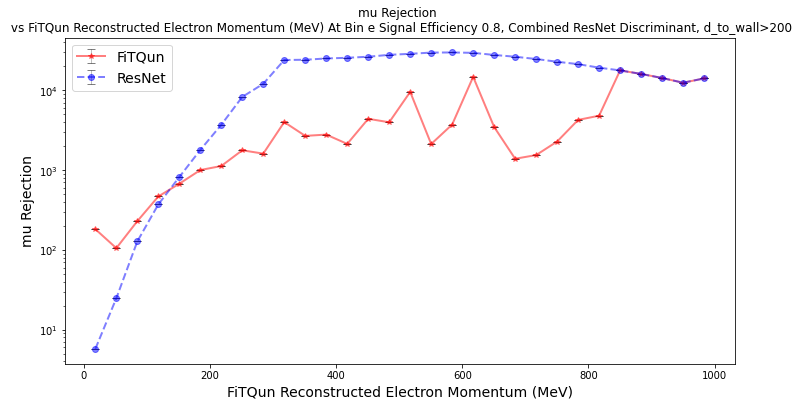

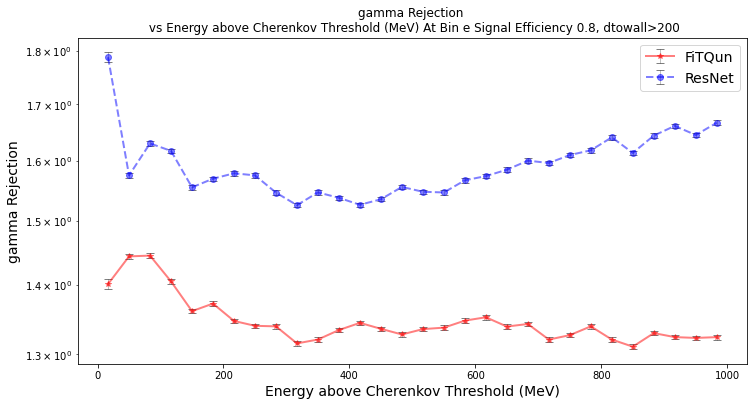

In [37]:
scores = [fq_scores, test_output[2]['filtered_softmaxes'], fq_scores, collapsed_sm, fq_scores, collapsed_sm, -fq_scores, test_output[2]['filtered_softmaxes']]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [shifted_energies,shifted_energies,np.clip(fq_mom[:,0], 0, 1000),shifted_energies]
feature_labels = ['Energy above Cherenkov Threshold (MeV)', 'Energy above Cherenkov Threshold (MeV)','FiTQun Reconstructed Electron Momentum (MeV)','Energy above Cherenkov Threshold (MeV)']
title_notes = [', dtowall>200',', Combined ResNet Discriminant, dtowall>200',', Combined ResNet Discriminant, dtowall>200',', dtowall>200']
pos_labels = ['e','e','e','e']
neg_labels = ['mu','mu','mu','gamma']
img_names=['rejection_vs_e.pdf','rejection_vs_e_combined_disc.pdf', 'rejection_vs_recon_e_combined_disc.pdf', 'e_gamma_rejection_vs_e.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i][dwall_over_200_idxs],
            labels[2*i][dwall_over_200_idxs],
            binning_features[i][dwall_over_200_idxs],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1][dwall_over_200_idxs],
            labels[2*i+1][dwall_over_200_idxs],
            binning_features[i][dwall_over_200_idxs],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i]))
    
scores = [fq_scores, test_output[2]['filtered_softmaxes'], fq_scores, collapsed_sm, fq_scores, collapsed_sm, -fq_scores, test_output[2]['filtered_softmaxes']]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [shifted_energies,shifted_energies,np.clip(fq_mom[:,0], 0, 1000),shifted_energies]
feature_labels = ['Energy above Cherenkov Threshold (MeV)', 'Energy above Cherenkov Threshold (MeV)','FiTQun Reconstructed Electron Momentum (MeV)','Energy above Cherenkov Threshold (MeV)']
title_notes = [', dtowall>200',', Combined ResNet Discriminant, d_to_wall>200',', Combined ResNet Discriminant, d_to_wall>200',', dtowall>200']
pos_labels = ['e','e','e','e']
neg_labels = ['mu','mu','mu','gamma']
img_names=['rejection_vs_e.pdf','rejection_vs_e_combined_disc.pdf', 'rejection_vs_recon_e_combined_disc.pdf', 'e_gamma_rejection_vs_e.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i][dwall_over_200_idxs],
            labels[2*i][dwall_over_200_idxs],
            binning_features[i][dwall_over_200_idxs],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='inverse fpr',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1][dwall_over_200_idxs],
            labels[2*i+1][dwall_over_200_idxs],
            binning_features[i][dwall_over_200_idxs],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='inverse fpr',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun','ResNet'],fontsize=14)
    if i==1:
        plt.savefig(os.path.join(os.getcwd(),'plot_images','energy_binning_dtowall_over_200.pdf'))

In [38]:
collapsed_sm_1, collapsed_labels_1 = collapse_test_output(repeat_1['filtered_softmaxes'][dwall_over_200_idxs],
                                                                 repeat_1['filtered_labels'][dwall_over_200_idxs],
                                                                 softmax_index_dict)

fprs, tprs, thresholds = zip(*[prep_roc_data(collapsed_sm_1,collapsed_labels_1,
                                'rejection',softmax_index_dict,"e","mu"),
                               prep_roc_data(fq_scores[dwall_over_200_idxs],fq_labels[dwall_over_200_idxs],
                                'rejection',softmax_index_dict,"e","mu")
                              ]
                            )

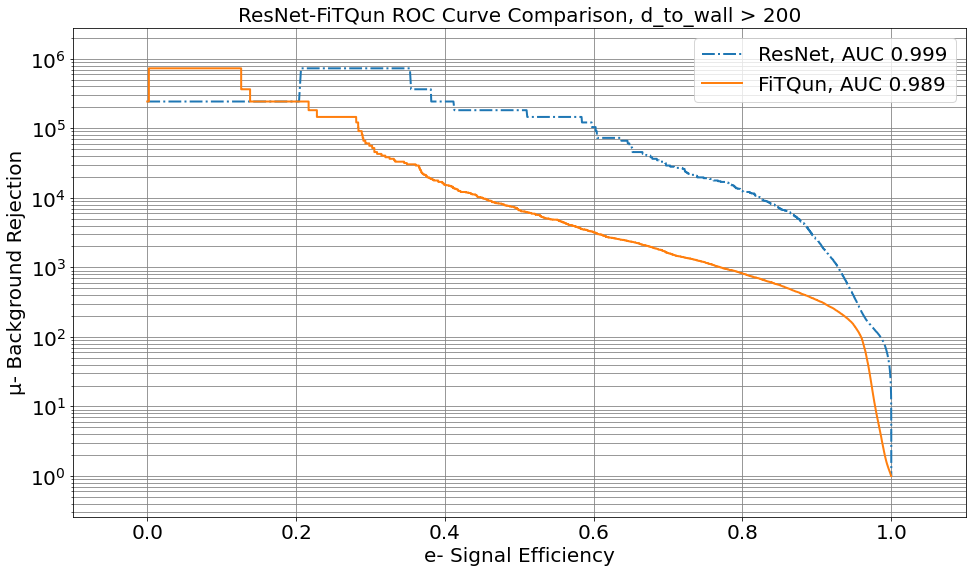

In [39]:
roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "mu"],['e','mu']], 
                                plot_labels = ['ResNet', 'FiTQun'],
                                title='ResNet-FiTQun ROC Curve Comparison, d_to_wall > 200',annotate=False,
                                linestyle=('dashdot','-','--'), xlabel='e- Signal Efficiency',ylabel='\u03BC- Background Rejection')
plt.savefig(os.path.join(os.getcwd(),'plot_images','roc_dtowall_over_200.pdf'))

### Binning in d-to-wall

/home/cmacdonald/CNN/ResNet_Analysis/repeating_classifier_training_utils.py:966: RuntimeWarning: divide by zero encountered in true_divide
  elif metric == 'inverse fpr': performance = np.where(fps != 0, (fps +tns) / fps, fps+tns)
/home/cmacdonald/CNN/ResNet_Analysis/repeating_classifier_training_utils.py:966: RuntimeWarning: divide by zero encountered in true_divide
  elif metric == 'inverse fpr': performance = np.where(fps != 0, (fps +tns) / fps, fps+tns)


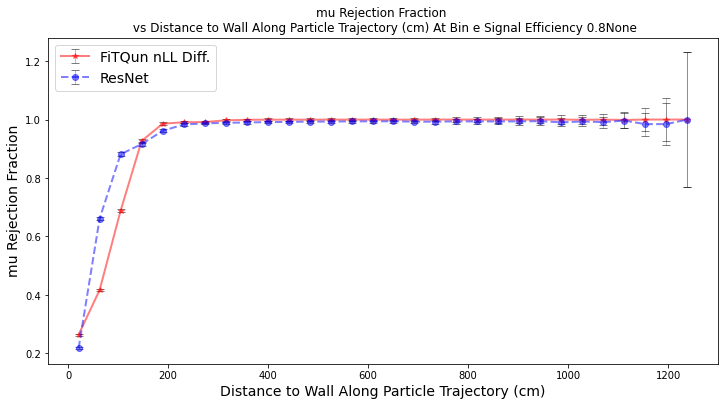

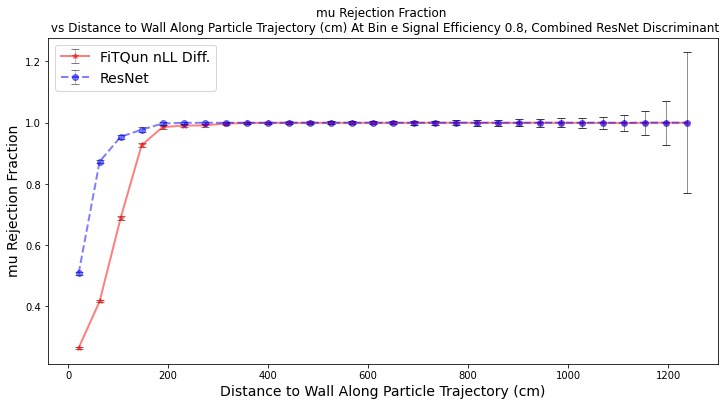

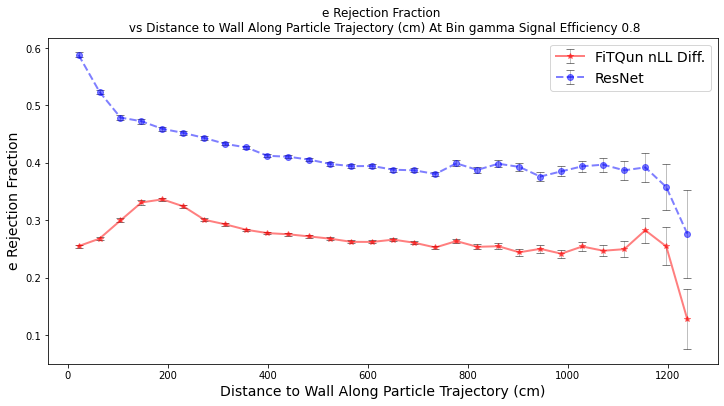

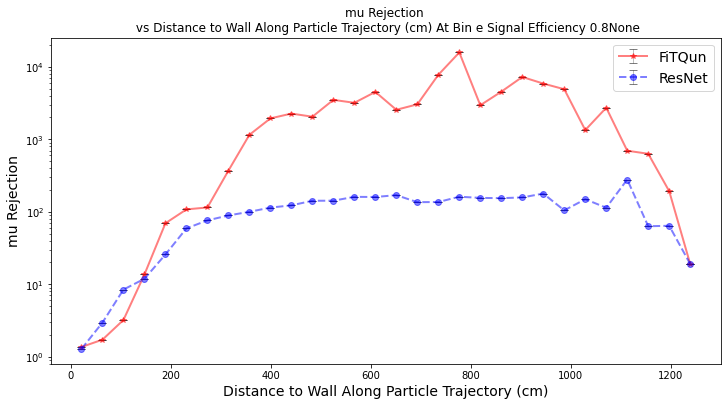

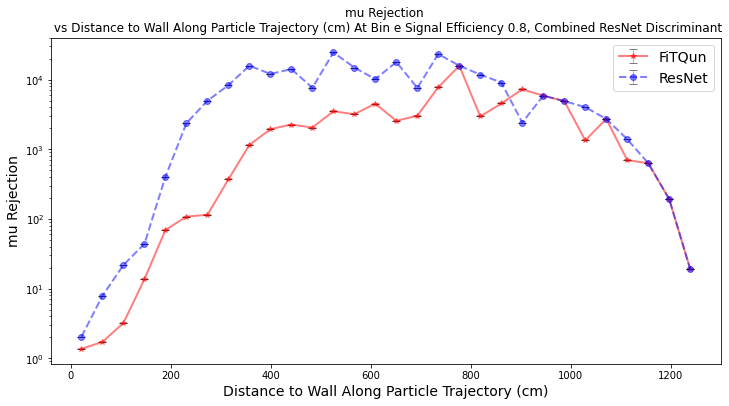

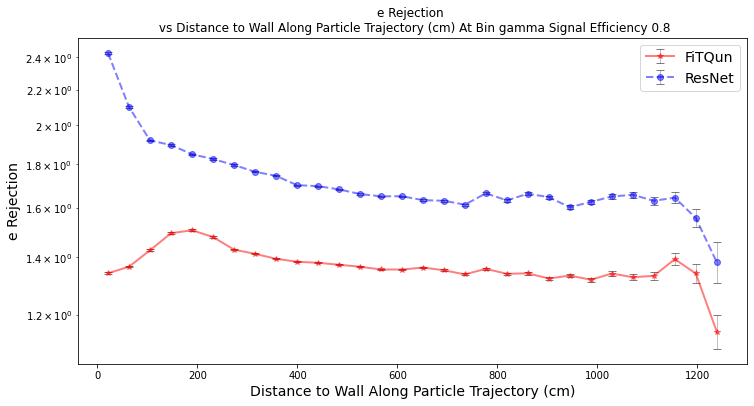

In [40]:
scores = [fq_scores, test_output[2]['filtered_softmaxes'], fq_scores, collapsed_sm, fq_scores, test_output[2]['filtered_softmaxes'] ]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [d_to_wall,d_to_wall,d_to_wall]
feature_labels = ['Distance to Wall Along Particle Trajectory (cm)','Distance to Wall Along Particle Trajectory (cm)','Distance to Wall Along Particle Trajectory (cm)']
title_notes = [None,', Combined ResNet Discriminant','']
pos_labels = ['e','e','gamma']
neg_labels = ['mu','mu','e']
img_names=['rejection_vs_dtowall.pdf','rejection_vs_dtowall_combined_disc.pdf', 'e_gamma_rejection_vs_dtowall.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    
scores = [fq_scores, test_output[2]['filtered_softmaxes'], fq_scores, collapsed_sm, fq_scores, test_output[2]['filtered_softmaxes'] ]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [d_to_wall,d_to_wall,d_to_wall]
feature_labels = ['Distance to Wall Along Particle Trajectory (cm)','Distance to Wall Along Particle Trajectory (cm)','Distance to Wall Along Particle Trajectory (cm)']
title_notes = [None,', Combined ResNet Discriminant','']
pos_labels = ['e','e','gamma']
neg_labels = ['mu','mu','e']
img_names=['rejection_vs_dtowall.pdf','rejection_vs_dtowall_combined_disc.pdf', 'e_gamma_rejection_vs_dtowall.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='inverse fpr',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='inverse fpr',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun','ResNet'],fontsize=14)
    if i==1:
        plt.savefig(os.path.join(os.getcwd(),'plot_images','dtowall_binning.pdf'))

### Binning in origin radius squared

/home/cmacdonald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  


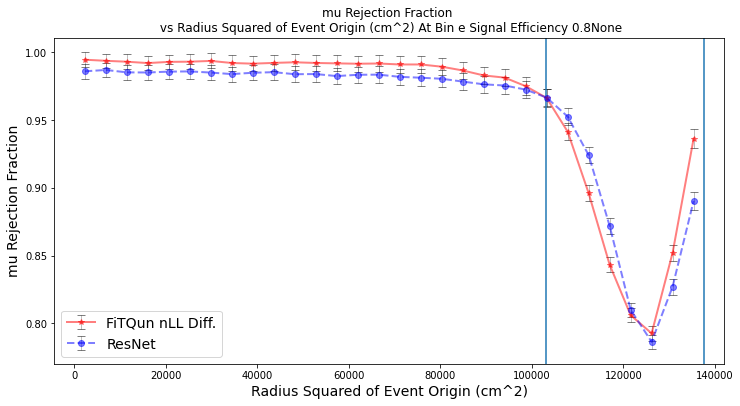

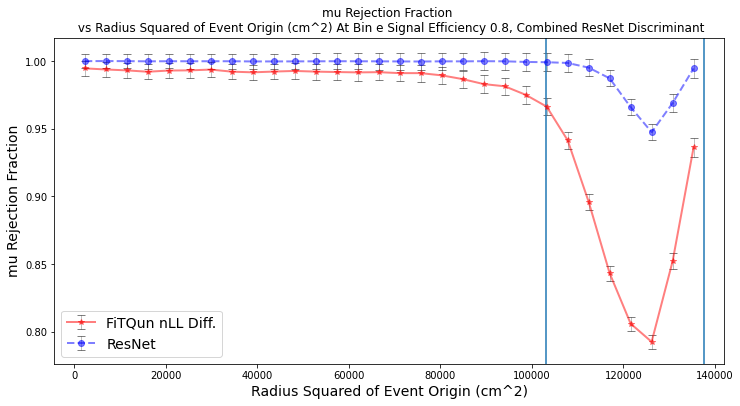

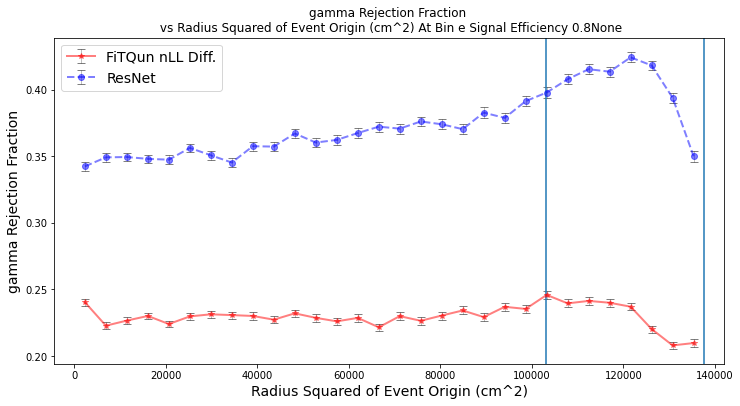

In [42]:
test_radius_incl_all = np.load('event_radii.npz')['test_radii']
test_radius_incl_flagged = np.delete(test_radius_incl_all, fq_failed_idxs)
test_radius = np.delete(test_radius_incl_flagged, fq_flagged_idxs)
test_radius = np.delete(test_radius, michel_idxs)

scores = [fq_scores, test_output[2]['filtered_softmaxes'], fq_scores, collapsed_sm, -fq_scores, test_output[2]['filtered_softmaxes'] ]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [test_radius**2,test_radius**2,test_radius**2]
feature_labels = ['Radius Squared of Event Origin (cm^2)' for _ in range(3)]
title_notes = [None,', Combined ResNet Discriminant',None]
pos_labels = ['e','e','e']
neg_labels = ['mu','mu','gamma']
img_names=['rejection_vs_radius.pdf','rejection_vs_radius_combined_disc.pdf', 'e_gamma_rejection_vs_radius.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    plt.axvline(x=371**2)
    plt.axvline(x=321**2)
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i]))

In [43]:
output_incl_flagged = load_test_output(os.path.join(paths[2], 'test_validation_iteration_dump.npz'), npz_path, remove_flagged=False)
rawfile = np.load(os.path.join(paths[2], 'test_validation_iteration_dump.npz'), allow_pickle=True)
sm_all = np.concatenate(list([batch_array for batch_array in rawfile['softmax']]))
labels_all = np.concatenate(list([batch_array for batch_array in rawfile['labels']]))

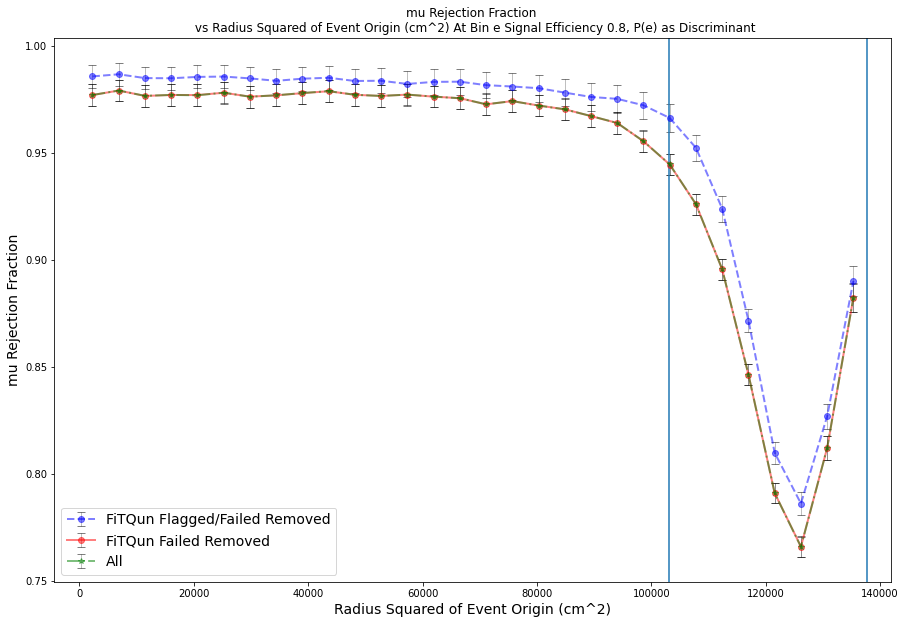

In [44]:
fig4, ax4 = plt.subplots(figsize=(15,10))
plot_binned_performance(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            test_radius**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='o--',color='b', ax=ax4, )

plot_binned_performance(output_incl_flagged['s_softmaxes'],
            output_incl_flagged['s_labels'],
            test_radius_incl_flagged**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='o-',color='r',ax=ax4)
plot_binned_performance(sm_all,
            labels_all,
            test_radius_incl_all**2,           
            'Radius Squared of Event Origin (cm^2)',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='*-.',color='g',title_note=', P(e) as Discriminant',ax=ax4)
ax4.legend(['FiTQun Flagged/Failed Removed','FiTQun Failed Removed', 'All'],fontsize=14)
plt.axvline(x=371**2)
plt.axvline(x=321**2)

In [45]:
#rest masses in MeV/c^2
E_REST_MASS = 0.510998
MUON_REST_MASS = 105.658
GAMMA_REST_MASS = 0
rest_masses = {softmax_index_dict['gamma']:GAMMA_REST_MASS, softmax_index_dict['e']:E_REST_MASS, softmax_index_dict['mu']:MUON_REST_MASS}
true_momentum = np.ones_like(repeat_1['filtered_energies'])
pbar = ProgressBar(widgets=['Find True Momentum: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
        ' ', ETA()], maxval=repeat_1['filtered_labels'].shape[0])
pbar.start()
for i, energy in enumerate(repeat_1['filtered_energies']):
    #true momentum in units of MeV/c
    pbar.update(i)
    true_momentum[i] = np.sqrt(energy**2 - rest_masses[repeat_1['filtered_labels'][i]]**2)
pbar.finish()

Find True Momentum: 100% [00000000000000000000000000000000000000] Time: 0:00:18


/home/cmacdonald/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  after removing the cwd from sys.path.
/home/cmacdonald/CNN/ResNet_Analysis/repeating_classifier_training_utils.py:965: RuntimeWarning: invalid value encountered in true_divide
  elif metric == 'rejection': performance = tns / (tns + fps)
/home/cmacdonald/CNN/ResNet_Analysis/repeating_classifier_training_utils.py:967: RuntimeWarning: invalid value encountered in double_scalars
  bin_metrics.append((efficiencies[operating_point_idx], performance[operating_point_idx], np.sqrt(tns[operating_point_idx])/(tns[operating_point_idx] + fps[operating_point_idx])))
/home/cmacdonald/CNN/ResNet_Analysis/repeating_classifier_training_utils.py:962: RuntimeWarning: invalid value encountered in true_divide
  efficiencies = tps/(tps + fns)
/home/cmacdonald/CNN/ResNet_Analysis/repeating_classifier_training_utils.py:965: RuntimeW

IndexError: cannot do a non-empty take from an empty axes.

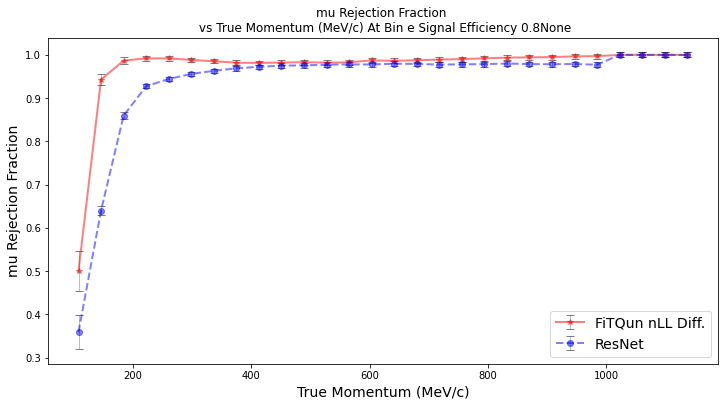

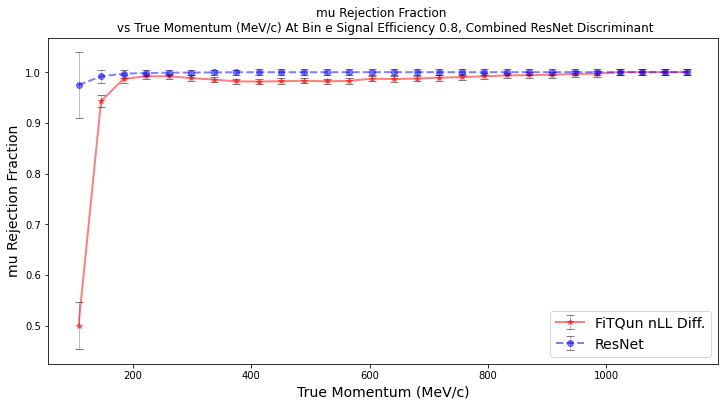

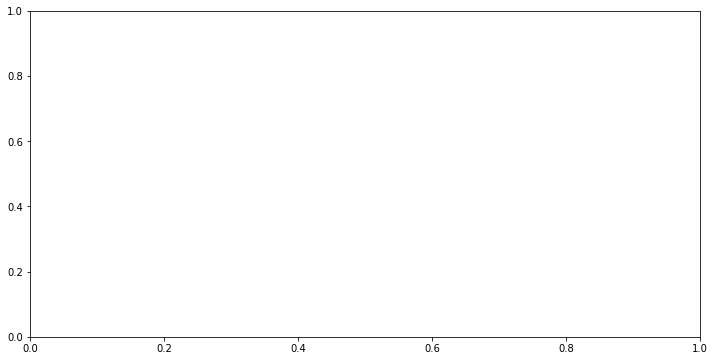

In [60]:
d_to_wall_incl_all = np.load('dist_to_wall.npz', allow_pickle=True)['test_d_to_wall']
fq_failed_idxs = np.load('Index_Storage/fq_failed_idxs.npz', allow_pickle=True)['failed_indices_pointing_to_h5_test_set']
fq_flagged_idxs = np.load('Index_Storage/fq_flagged_idxs.npz', allow_pickle=True)['arr_0']
d_to_wall_incl_flagged = np.delete(d_to_wall_incl_all, fq_failed_idxs)
d_to_wall = np.delete(d_to_wall_incl_flagged, fq_flagged_idxs)
d_to_wall = np.delete(d_to_wall, michel_idxs)

scores = [fq_scores, test_output[2]['filtered_softmaxes'], fq_scores, collapsed_sm, fq_scores, test_output[2]['filtered_softmaxes'] ]
labels = [fq_labels for _ in range(len(scores))]
binning_features = [true_momentum,true_momentum,true_momentum]
feature_labels = ['True Momentum (MeV/c)','True Momentum (MeV/c)','True Momentum (MeV/c)']
title_notes = [None,', Combined ResNet Discriminant','']
pos_labels = ['e','e','gamma']
neg_labels = ['mu','mu','e']
img_names=['rejection_vs_dtowall.pdf','rejection_vs_dtowall_combined_disc.pdf', 'e_gamma_rejection_vs_dtowall.pdf']
for i in range(len(pos_labels)):
    fig, ax = plt.subplots(figsize=(12,6))
    plot_binned_performance(scores[2*i],
            labels[2*i],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='*-',color='r',ax=ax )
    plot_binned_performance(scores[2*i+1],
            labels[2*i+1],
            binning_features[i],           
            feature_labels[i],
            0.8, 30, softmax_index_dict, pos_labels[i],neg_labels[i],metric='rejection',marker='o--',color='b',ax=ax,title_note=title_notes[i] )    
    ax.legend(['FiTQun nLL Diff.','ResNet'],fontsize=14)
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i]))

## Assessing FiTQun Using Reconstructed Momentum-Determined Thresholds

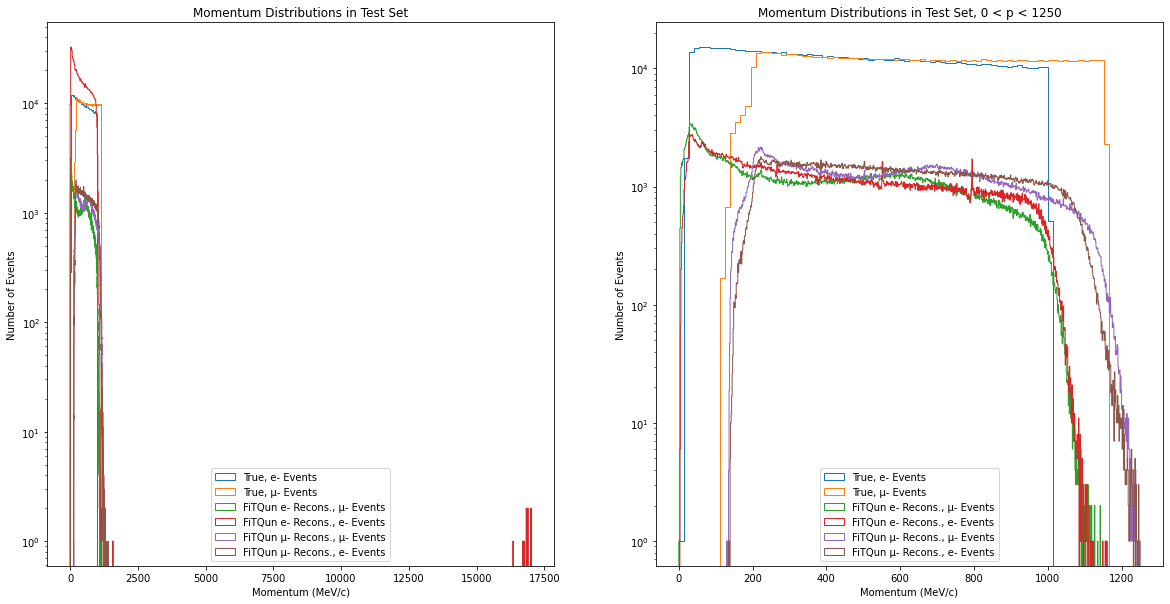

In [47]:
fig,axes=plt.subplots(1,2,figsize=(20,10))
muon_idxs=np.where(fq_labels==2)[0]
electron_idxs=np.where(fq_labels==1)[0]
for i, xrange in enumerate([None, [0,1250]]):
    ax=axes[i]
    ax.hist(true_momentum[electron_idxs],bins=90,range=xrange,histtype=u'step',label='True, e- Events')
    ax.hist(true_momentum[muon_idxs],bins=90,range=xrange,histtype=u'step',label='True, \u03BC- Events')
    ax.hist(fq_mom[muon_idxs,0],bins=900,range=xrange,histtype=u'step',label='FiTQun e- Recons., \u03BC- Events')
    ax.hist(fq_mom[electron_idxs,0],bins=900,range=xrange,histtype=u'step',label='FiTQun e- Recons., e- Events')
    ax.hist(fq_mom[muon_idxs,1],bins=900,range=xrange,histtype=u'step',label='FiTQun \u03BC- Recons., \u03BC- Events')
    ax.hist(fq_mom[electron_idxs,1],bins=900,range=xrange,histtype=u'step',label='FiTQun \u03BC- Recons., e- Events') 
    ax.set_xlabel('Momentum (MeV/c)')
    ax.set_ylabel('Number of Events')
    ax.legend(loc='lower center')
    ax.set_yscale('log')
    title = f'Momentum Distributions in Test Set, {xrange[0]} < p < {xrange[1]}' if xrange is not None else 'Momentum Distributions in Test Set'
    ax.set_title(title)

In [48]:
recon_mom_by_label = np.ones_like(fq_mom[:,0])
recon_mom_by_label[muon_idxs] = fq_mom[muon_idxs, 1]
recon_mom_by_label[electron_idxs] = fq_mom[electron_idxs, 0]

In [53]:
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

odv_file = h5py.File('/fast_scratch/WatChMaL/data/IWCDmPMT_4pm_full_tank_ODveto.h5','r')
odv_mapping_idxs = np.load(os.path.join(npz_path, 'od_veto_mapping_idxs.npz'),allow_pickle=True)['mapping_idxs_full_set']
od_veto = np.array(odv_file['veto'])[odv_mapping_idxs]


original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")
original_positions=np.array(f['positions'])
test_positions = original_positions[test_filtered_indices]
f.close()

failed_idxs = np.load(os.path.join(npz_path, 'fq_failed_idxs.npz'),allow_pickle=True)['failed_indices_pointing_to_h5_test_set'].astype(int)
flagged_idxs = np.load(os.path.join(npz_path, 'fq_flagged_idxs.npz'),allow_pickle=True)['arr_0'].astype(int)

test_positions = np.delete(test_positions, failed_idxs,0)
test_positions = np.delete(test_positions, flagged_idxs,0)
test_positions = np.delete(test_positions, michel_idxs, 0)

od_veto = np.delete(od_veto, failed_idxs)
od_veto = np.delete(od_veto, flagged_idxs)
od_veto = np.delete(od_veto, michel_idxs)

test_positions = np.squeeze(test_positions, axis=1)

In [62]:
test_zs = test_positions[:,1]
origin_to_wall = np.array([np.min((371-test_radius[i],521 - test_zs[i], test_zs[i] + 521)) for i in range(test_zs.shape[0])])
origin_to_wall_cut_remove_idxs = np.where(origin_to_wall < 50)[0]
e_specific_cut_remove_idxs = np.where((fq_labels==1)&(d_to_wall < 0.63 * np.log(true_momentum) - 2))[0]
muon_specific_veto_remove_idxs = np.where((fq_labels==2)&(od_veto==1))[0]
remove_idxs = np.concatenate((origin_to_wall_cut_remove_idxs, e_specific_cut_remove_idxs,muon_specific_veto_remove_idxs))

In [63]:
official_scores = np.delete(fq_scores, remove_idxs,0)
official_labels = np.delete(fq_labels, remove_idxs)
official_true_mom = np.delete(true_momentum, remove_idxs)
official_fq_mom = np.delete(fq_mom[:,0], remove_idxs)

In [64]:
rn_official_scores = np.delete(repeat_1['filtered_softmaxes'],remove_idxs,0)

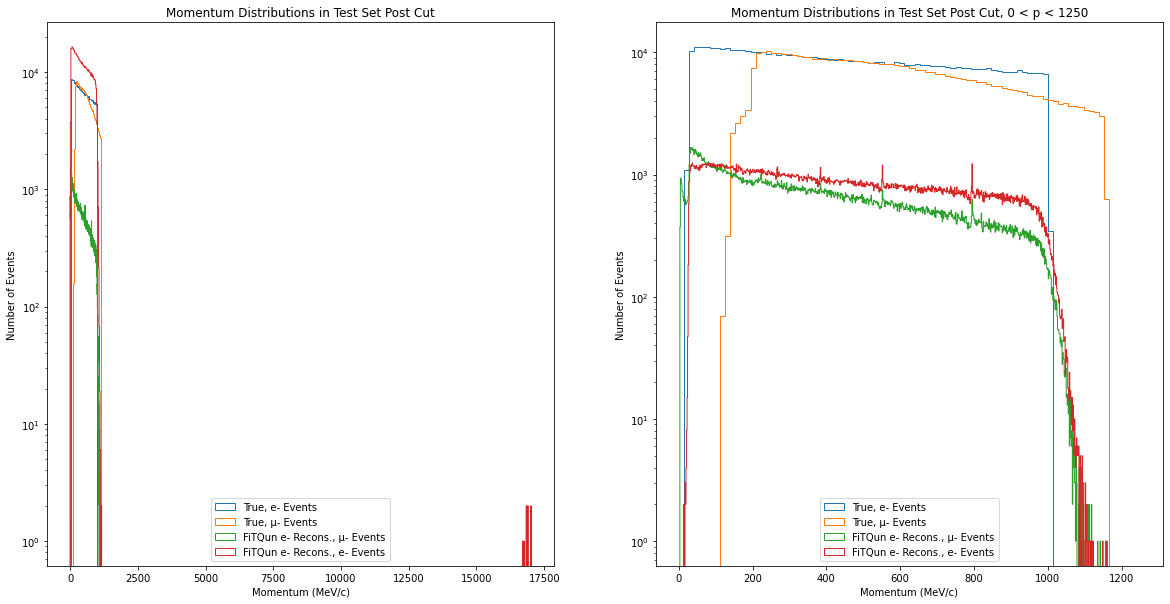

In [65]:
fig,axes=plt.subplots(1,2,figsize=(20,10))
muon_idxs=np.where(official_labels==2)[0]
electron_idxs=np.where(official_labels==1)[0]
for i, xrange in enumerate([None, [0,1250]]):
    ax=axes[i]
    ax.hist(official_true_mom[electron_idxs],bins=90,range=xrange,histtype=u'step',label='True, e- Events')
    ax.hist(official_true_mom[muon_idxs],bins=90,range=xrange,histtype=u'step',label='True, \u03BC- Events')
    ax.hist(official_fq_mom[muon_idxs],bins=900,range=xrange,histtype=u'step',label='FiTQun e- Recons., \u03BC- Events')
    ax.hist(official_fq_mom[electron_idxs],bins=900,range=xrange,histtype=u'step',label='FiTQun e- Recons., e- Events') 
    ax.set_xlabel('Momentum (MeV/c)')
    ax.set_ylabel('Number of Events')
    ax.legend(loc='lower center')
    ax.set_yscale('log')
    title = f'Momentum Distributions in Test Set Post Cut, {xrange[0]} < p < {xrange[1]}' if xrange is not None else 'Momentum Distributions in Test Set Post Cut'
    ax.set_title(title)

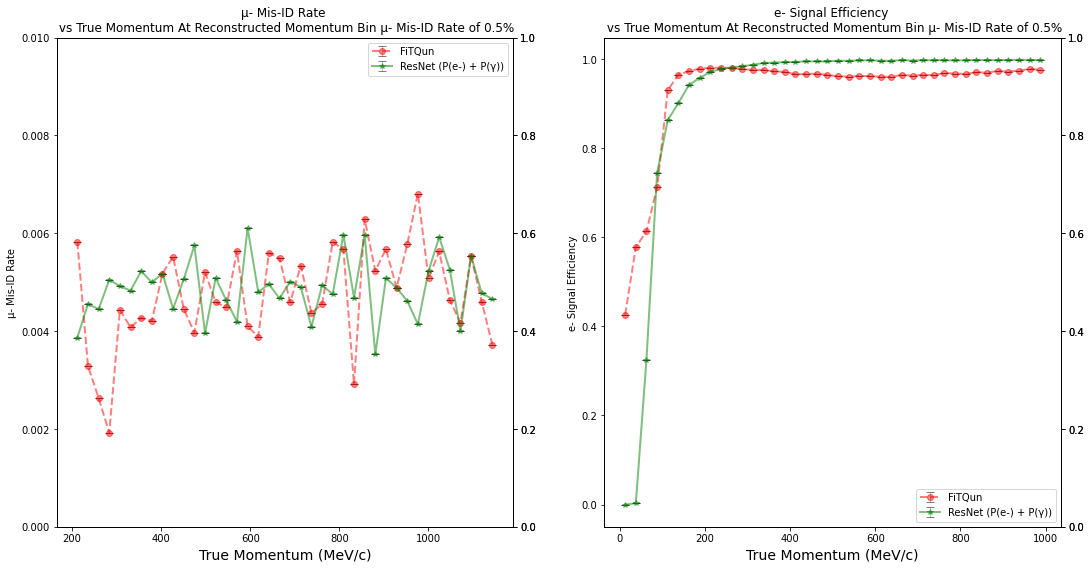

In [66]:
fig,axes  =plt.subplots(1,2,figsize=(18,9))
for i, metric in enumerate(['mu fpr', 'efficiency']):
    plot_fitqun_binned_performance(official_scores[:,1], official_labels, official_true_mom, np.clip(official_fq_mom,0,1160), 0.005, softmax_index_dict, 
                                ax=axes[i],marker='o--',color='r',title_note='',metric=metric,yrange=[0,0.01] if i==0 else None,true_mom_bins=40)
    momentum,thresholds_per_event = plot_fitqun_binned_performance(np.delete(repeat_1['filtered_softmaxes'][:,1] + repeat_1['filtered_softmaxes'][:,0] ,remove_idxs,0), official_labels, official_true_mom, np.clip(official_fq_mom,0,1160), 0.005, softmax_index_dict, 
                                ax=axes[i],marker='*-',color='g',title_note='',metric=metric,yrange=[0,0.01] if i==0 else None,true_mom_bins=40)
    axes[i].legend(['FiTQun','ResNet (P(e-) + P(\u03B3))'])

/home/cmacdonald/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/cmacdonald/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Operating Point Threshold')

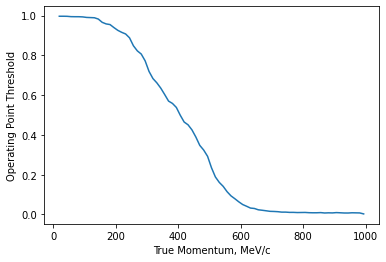

In [67]:
_,bins = np.histogram(momentum, bins=80, range=(0,1000))
bins = bins[0:-1]
bin_assignments = np.digitize(momentum, bins)
average_thresh_list = []
for bin_idx in range(len(bins)):
    bin_num = bin_idx + 1 #these are one-indexed for some reason
    this_bin_idxs = np.where(bin_assignments == bin_num)[0]
    average_thresh_list.append(np.mean(thresholds_per_event[this_bin_idxs]))
bin_centers = [(bins[i+1] - bins[i])/2 + bins[i] for i in range(0,len(bins)-1)]
bin_centers.append((1000 - bins[-1])/2 + bins[-1])
plt.plot(bin_centers, average_thresh_list)
plt.xlabel('True Momentum, MeV/c')
plt.ylabel('Operating Point Threshold')

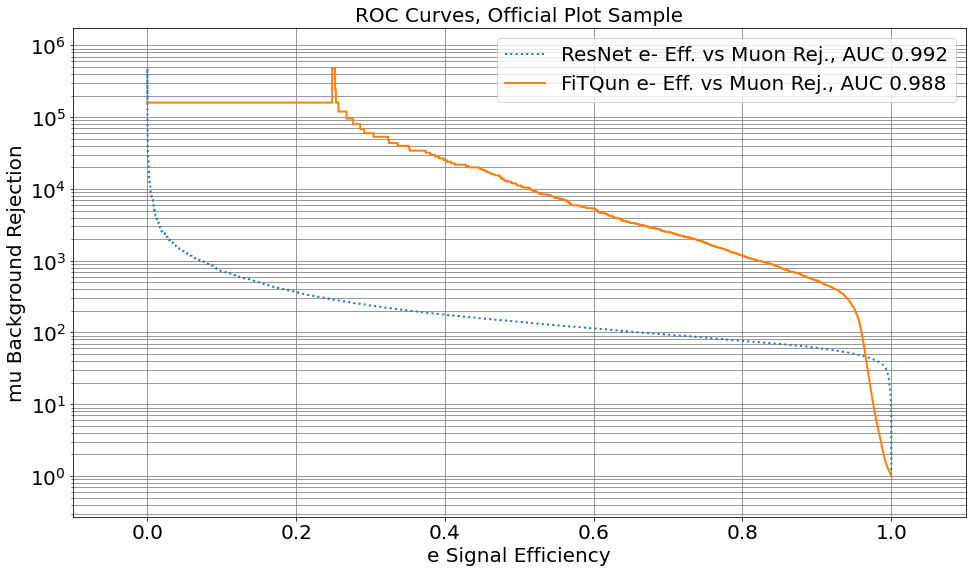

In [68]:
collapsed_sm_official, collapsed_labels_official = collapse_test_output(rn_official_scores,
                                                                 official_labels,
                                                                 softmax_index_dict, ignore_type="gamma")
rn_fprs, rn_tprs, rn_thresholds = prep_roc_data(rn_official_scores,official_labels,
                                'rejection',softmax_index_dict,"e","mu")
fprs = [rn_fprs]
tprs = [rn_tprs]
thresholds = [rn_thresholds]
fq_official_fprs,fq_official_tprs,fq_official_threshs = prep_roc_data(official_scores, official_labels,'rejection',softmax_index_dict,"e","mu")

fprs.append(fq_official_fprs)
tprs.append(fq_official_tprs)
thresholds.append(fq_official_threshs)

roc_metrics = plot_multiple_ROC((fprs, tprs, thresholds),'rejection', [["e", "mu"],['e','mu']], 
                                plot_labels = ['ResNet e- Eff. vs Muon Rej.','FiTQun e- Eff. vs Muon Rej.'],
                                png_name = 'overlaid_roc',title='ROC Curves, Official Plot Sample',annotate=False,linestyle=(':','-','--'))

## Plot Classifier Response

### Previous Run

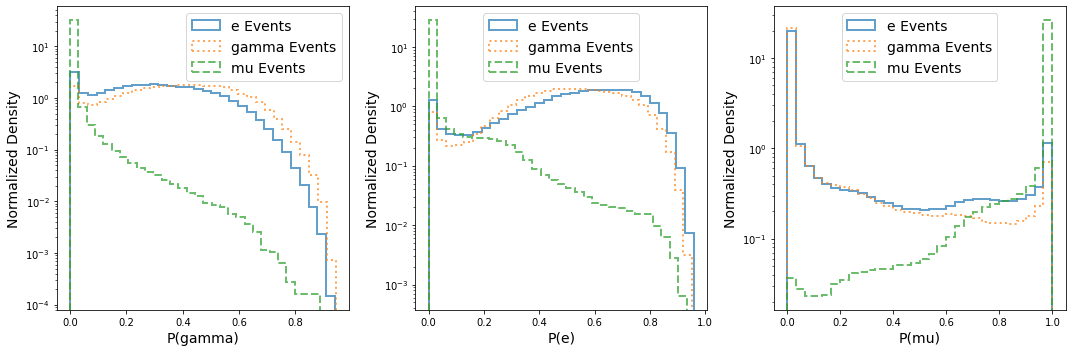

In [69]:
fig = plot_response(tia_out['filtered_softmaxes'], tia_out['filtered_labels'], ['e','gamma','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                    'upper center'])

### Repeat Run 2

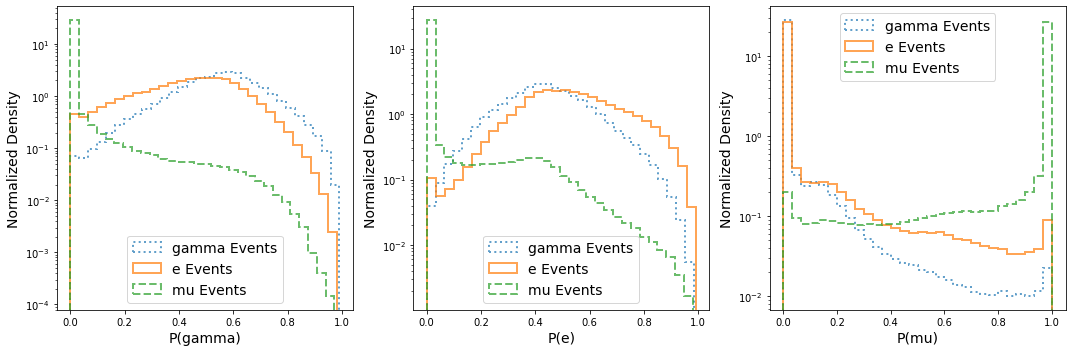

In [70]:
fig=plot_response(test_output[2]['filtered_softmaxes'], test_output[2]['filtered_labels'], ['gamma','e','mu'], 
                    softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['lower center', 'lower center', 'upper center',
                                                                                    'upper center'])
plt.savefig(os.path.join(os.getcwd(),'plot_images/resnet_response.pdf'))

In [71]:
ns,bins = np.histogram(shifted_energies, bins=5)
left_edges = bins[0:-1]
bin_assignments = np.digitize(shifted_energies, left_edges)

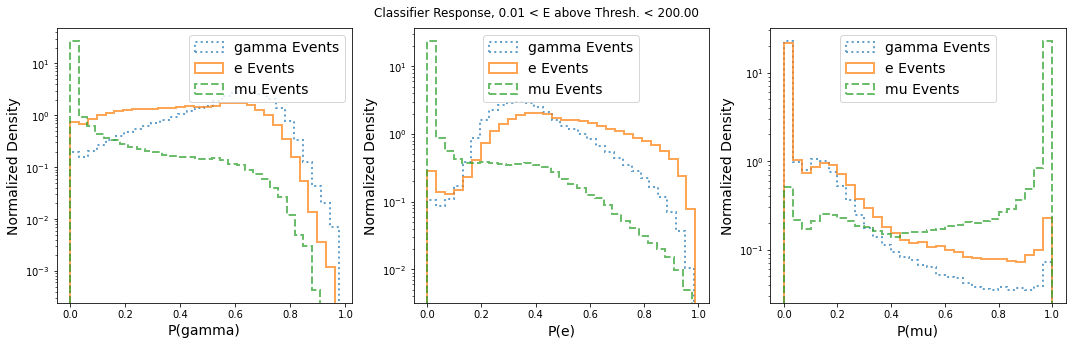

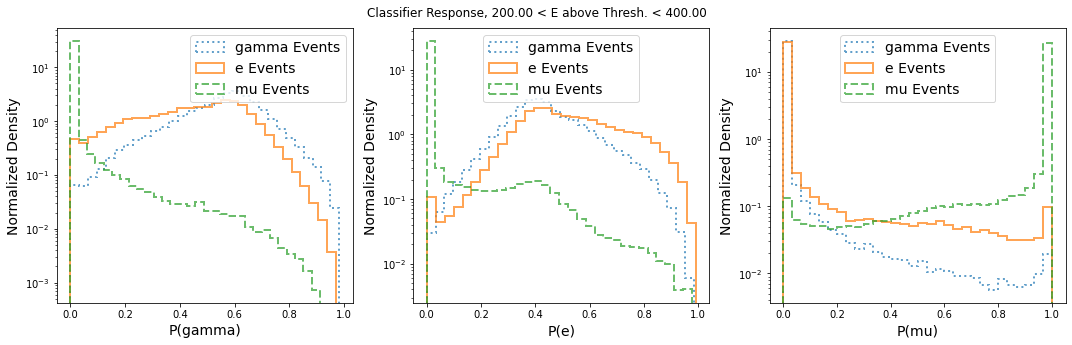

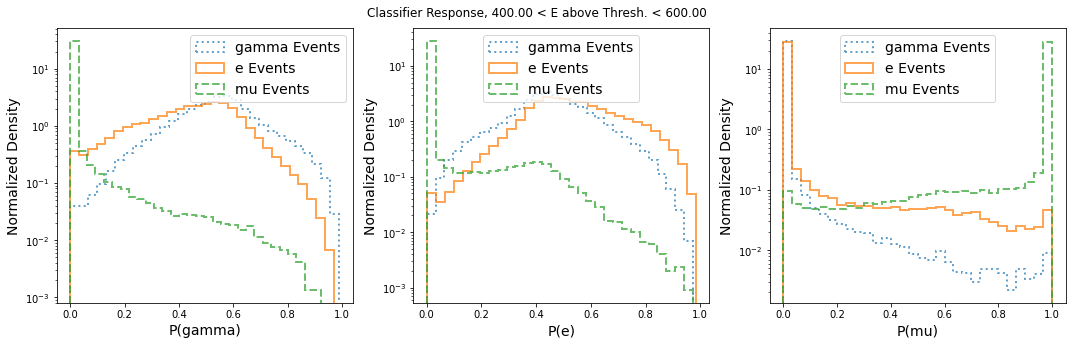

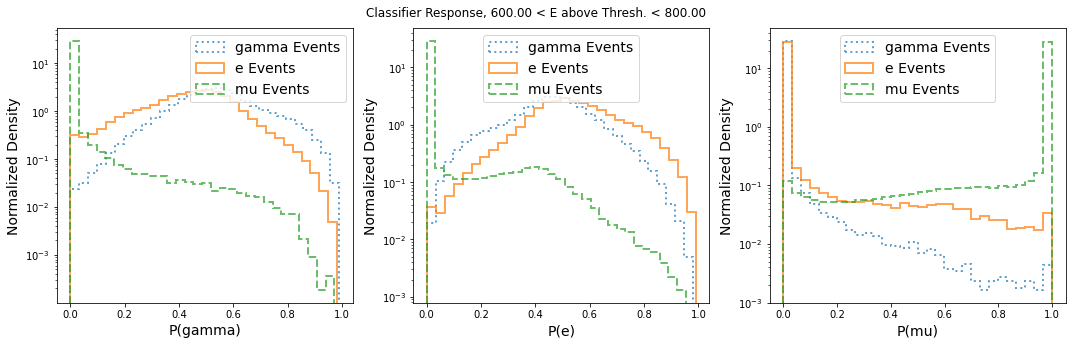

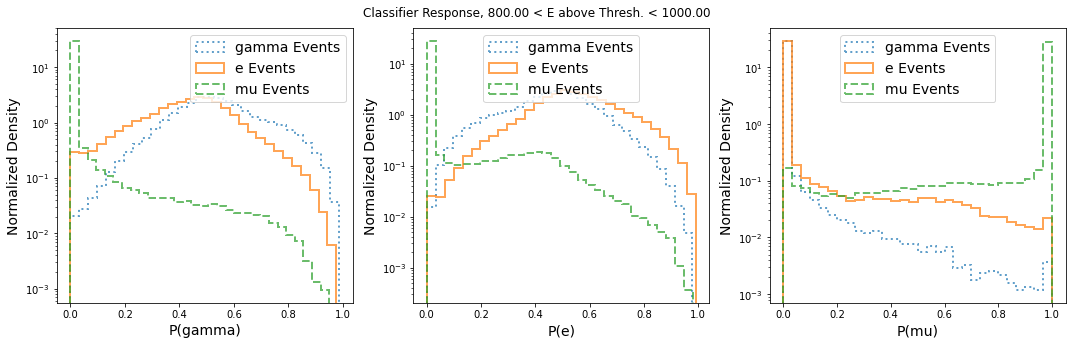

In [72]:
for BIN_NUM in range(1,6):
    bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
    fig = plot_response(repeat_1['filtered_softmaxes'][bin_idxs,:], repeat_1['filtered_labels'][bin_idxs], ['gamma','e','mu'], 
                        softmax_index_dict, bins=30,linestyle=(':','-','--'),legend_locs=['best', 'upper center', 'upper center',
                                                                                        'upper center'])
    a = fig.suptitle(f'Classifier Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(os.path.join(os.getcwd(),f'plot_images/resnet_1d_binned_response_bin{BIN_NUM}.pdf'))

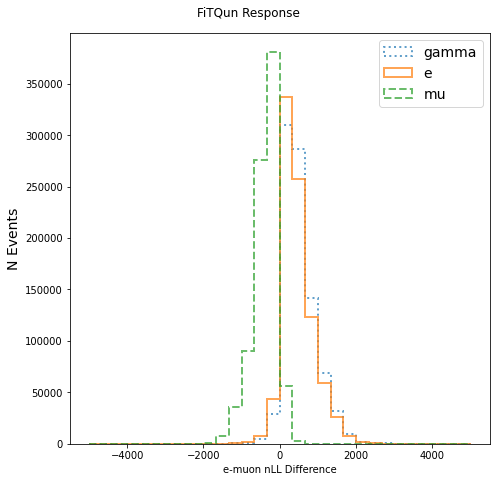

In [73]:
fig = plot_response(fq_scores, fq_labels, ['gamma','e','mu'], 
                    softmax_index_dict, linestyle=(':','-','--'), bins=30,legend_locs=['best'], fitqun=True, 
                    xlim = [-5000,5000])
a = fig.suptitle(f'FiTQun Response')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [74]:
for i in range(fq_labels.shape[0]):
    assert fq_labels[i] == repeat_1['filtered_labels'][i]
assert fq_labels.shape[0] == repeat_1['filtered_labels'].shape[0]

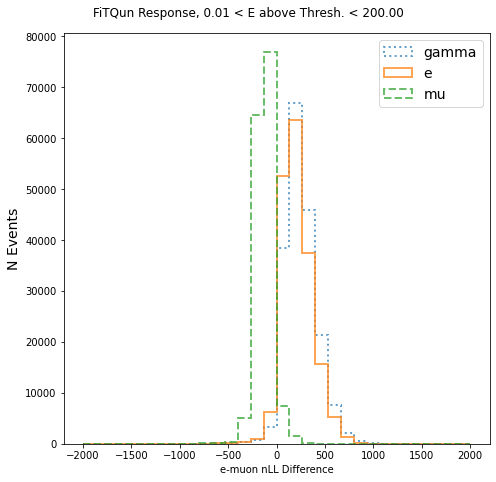

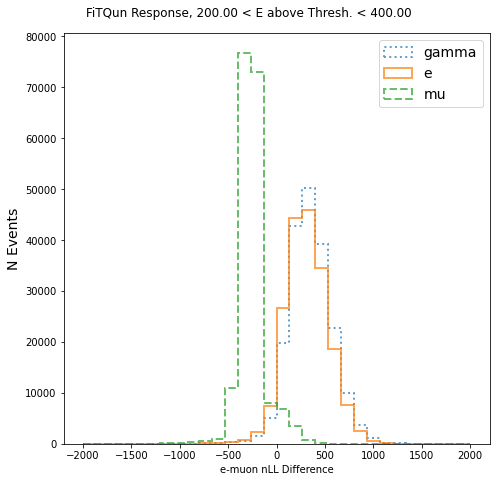

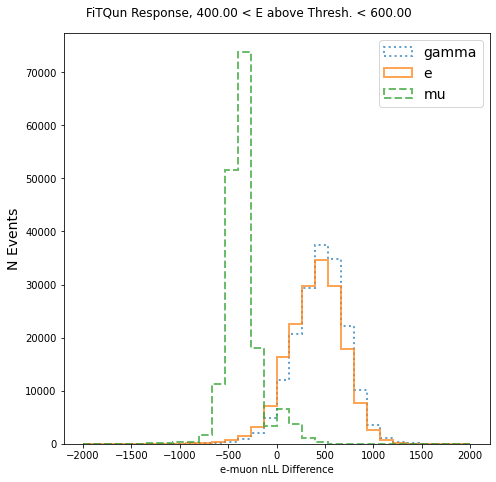

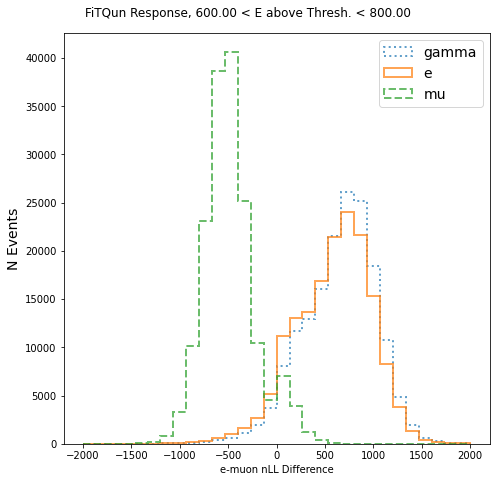

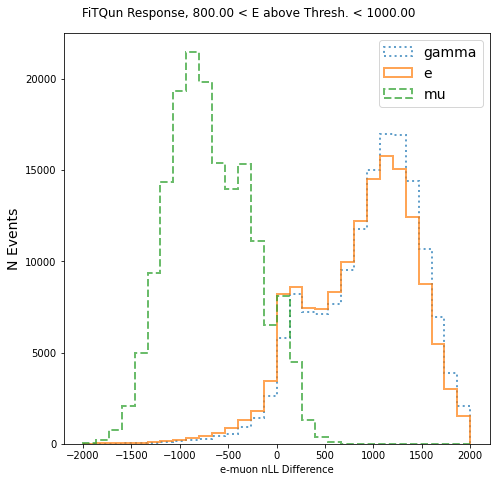

In [75]:
for BIN_NUM in range(1,6):
    bin_idxs = np.where(bin_assignments == BIN_NUM)[0]
    fig = plot_response(fq_scores[bin_idxs], fq_labels[bin_idxs], ['gamma','e','mu'], 
                        softmax_index_dict, bins=30,linestyle=(':','-','--'),
                        legend_locs=['best', 'upper center', 'upper center','upper center'], xlim=[-2000,2000],fitqun=True)
#     print(f"Max: {np.max(fq_scores[bin_idxs])} Min: {np.min(fq_scores[bin_idxs])}")
    a = fig.suptitle(f'FiTQun Response, {np.abs(bins[BIN_NUM-1]):.2f} < E above Thresh. < {bins[BIN_NUM]:.2f}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

## Plot Binned Response

In [76]:
binning_features = [shifted_energies, test_radius**2, d_to_wall]
binning_labels=['Energy above Cherenkov Threshold (MeV)','Radius Squared of Event Origin (cm^2)',
                'Trajectory Distance to Wall (cm)']

In [77]:
img_names = ['2d_resnet_binned_response_energy.pdf','2d_resnet_binned_response_radius.pdf','2d_resnet_binned_response_dtowall.pdf']
for i in range(len(binning_features)):
    fig = plot_binned_response(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            binning_features[i],           
            binning_labels[i],
            0.8, 30, 30,softmax_index_dict,
            log_scales=[2,6,8,9,11,3,7,10]
            )
    plt.savefig(os.path.join(os.getcwd(),'plot_images',img_names[i])) 

TypeError: plot_binned_response() missing 1 required positional argument: 'index_dict'

## Impact of Cap/Barrel Interface

In [ ]:
# Import test events from h5 file
filtered_index = "/fast_scratch/WatChMaL/data/IWCD_fulltank_300_pe_idxs.npz"
filtered_indices = np.load(filtered_index, allow_pickle=True)
test_filtered_indices = filtered_indices['test_idxs']

original_data_path = "/data/WatChMaL/data/IWCDmPMT_4pi_fulltank_9M.h5"
f = h5py.File(original_data_path, "r")

hdf5_event_data = (f["event_data"])
original_eventdata = np.memmap(original_data_path, mode="r", shape=hdf5_event_data.shape,
                                    offset=hdf5_event_data.id.get_offset(), dtype=hdf5_event_data.dtype)

good_idxs = np.delete(test_filtered_indices, failed_idxs)
good_idxs = np.delete(good_idxs, flagged_idxs)
f.close()

In [ ]:
from utils.plot_utils import get_plot_array
import matplotlib
fig, axes = plt.subplots(1,1,figsize=(25,25),facecolor='w')
cmap = plt.cm.viridis
cmap.set_bad(color='black')
ax = axes
event = np.array(original_eventdata[good_idxs[np.random.randint(0,high=good_idxs.shape[0])],:,:,0:19])
event[:,:,:] = 1
event[:12,:,:] = 10/2
event[28:,:,:] = 10/3
a=get_plot_array(event)
#     a = np.ma.masked_where(a < 0.05, a)
ax.imshow(a,
           origin="upper",
           cmap=cmap,
           norm=matplotlib.colors.LogNorm(vmax=np.amax(a),
                                         clip=True))
plt.show()

In [ ]:
def chunks(lst, n):
    for i in range(0,len(lst),n):
        yield lst[i:i+n]

In [ ]:
cap_fraction = np.ones_like(good_idxs, dtype=float)
idx_chunks = list(chunks(range(good_idxs.shape[0]), 5000))
pbar = ProgressBar(widgets=['Calculating Fractions. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=len(idx_chunks))
pbar.start()
for i, idx_chunk in enumerate(idx_chunks):
    data = np.array(original_eventdata[idx_chunk])
    cap_fraction[idx_chunk]= np.sum(np.concatenate((data[:,0:12,:,0:19],data[:,28:,:,0:19]),axis=1), (1,2,3))/np.sum(data[:,12:28,:,0:19], (1,2,3))
    pbar.update(i)
pbar.finish()

In [ ]:
np.savez('cap_fraction.npz',cap_fraction=cap_fraction)

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
plot_binned_performance(test_output[2]['filtered_softmaxes'],
            test_output[2]['filtered_labels'],
            np.clip(cap_fraction,0,2),           
            'Cap Charge Sum / Barrel Charge Sum (clipped to [0,2])',
            0.8, 30, softmax_index_dict, 'e','mu',metric='rejection',marker='o-',color='r',ax=ax, )
# ax.twinx().hist(cap_fraction, histtype=u'step')